# Dual prediction of `domain2` using multi-loss neural network

Given the particular relationship between `domain2_var1` and `domain2_var2`, which I showed in [first notebook](https://www.kaggle.com/miykael/trends-exploration-of-the-targets)), I pursued an dense neural network modeling approach, with multi-loss. The idea was to find a prediction for the two `domain2` variables that is close to the original values, but where the rotated values are also close to the rotated predictions.

As a note, in this notebook I will be using the adapted targets, as well as the engineered features I've explored in my [second notebook](https://www.kaggle.com/miykael/trends-feature-exploration-engineering)).

In [1]:
import numpy as np
import pandas as pd
from os.path import join as opj
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

In [3]:
from sklearn.model_selection import ParameterGrid, KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.2.0'

# 1. Load targets and features

First things first, let's load the adapted targets and prepared feature datasets from my [second notebook](https://www.kaggle.com/miykael/trends-feature-exploration-engineering).

In [4]:
path = '/kaggle/input/trends-feature-exploration-engineering/datasets'

In [5]:
# Load target values and corresponding scaler
import joblib
scaler_targets = joblib.load(opj(path, 'targets_scaler.pkl'))

targets = pd.read_hdf(opj(path, 'targets.h5'))
targets.head()

age  domain1_var1  domain1_var2  domain2_var1  domain2_var2  \
Id                                                                        
10001  0.546728     -1.899398      0.252044      0.508042     -0.101181   
10002  0.705146     -0.100839      0.716626      1.248698      0.511050   
10004  1.579096      0.117249     -0.161179      0.419738      0.905470   
10005  1.218620           NaN           NaN      0.389779      1.634315   
10007 -0.843261     -0.274512      0.544862     -0.697195     -1.459928   

        d21_rot   d22_rot  
Id                         
10001  0.228396 -0.486307  
10002  1.091555 -0.635136  
10004  0.936611  0.244955  
10005  1.449477  0.712967  
10007 -1.458821 -0.514022

To load the feature matrix, let's write a function that performs the following steps:

1. Load the train and test set.
2. Select the two `domain2` targets.
3. Centralize the corr_coef features to the median, which is about 0.689
4. Scale the four feature datasets (IC, FNC, intra and inter correlations) according to a scaler called `scale_values`. Before this scaler is applied, all feature within a dataset are scaled to the 90% value (i.e. top 10%). No centralization was applied.
5. Missing values are dropped.

In [6]:
def load_dataset_and_scale(dataset_id='merge', scale_values=[1, 1, 1, 1]):

    # Load dataset
    X_tr = pd.read_hdf(opj(path, '%s_train.h5' % dataset_id))
    X_te = pd.read_hdf(opj(path, '%s_test.h5' % dataset_id))

    # Specify target
    y = pd.read_hdf(opj(path, 'targets.h5'))
    y_tr = y.loc[X_tr.index, 'domain2_var1':]

    # Remove missing values
    missval = y_tr.isnull().sum(axis=1)!=0
    idx = ~missval
    X_tr = X_tr[idx]
    X_te = X_te
    y_tr = y_tr[idx]
    print('Removing %s missing values from target dataset.' % missval.sum())
    
    # Centralize corr_coef features
    median_offset = X_tr.iloc[:, X_tr.columns.str.contains('corr_coef')].median().mean()
    X_tr.iloc[:, X_tr.columns.str.contains('corr_coef')] -= median_offset
    X_te.iloc[:, X_te.columns.str.contains('corr_coef')] -= median_offset

    # Establish masks for different kinds of data
    mask_ids = []
    for m in ['IC_', '_vs_', 'corr_coef', '^c[0-9]+_c[0-9]+']:
        mask_ids.append(X_tr.columns.str.contains(m))
    mask_ids = np.array(mask_ids)

    # Data scaling
    for i, m in enumerate(mask_ids):

        if m.sum()==0:
            continue
        
        # Apply Scale
        scale_value = scale_values[i]
        unify_mask_scale = np.percentile(X_tr.iloc[:, m].abs(), 90)

        X_te.iloc[:, m] /= unify_mask_scale
        X_tr.iloc[:, m] /= unify_mask_scale
    
        X_te.iloc[:, m] *= scale_value
        X_tr.iloc[:, m] *= scale_value

    # Drop irrelevant measurements
    X_tr.dropna(axis=1, inplace=True)
    X_te.dropna(axis=1, inplace=True)
    
    # Drop duplicate rows
    X_tr = X_tr.T.drop_duplicates().T
    X_te = X_te.T.drop_duplicates().T
    
    print('Size of dataset (train/test): ', X_tr.shape, X_te.shape)
    
    X_tr = X_tr.values
    X_te = X_te.values
    y_tr = y_tr.values
    
    return X_tr, X_te, y_tr

To refresh our memories about which `domain2` relationship we want to profit from, let's visualize it.

In [7]:
# Load the data
X_tr, X_te, y_tr = load_dataset_and_scale(dataset_id='merge', scale_values=[1, 1, 1, 1])

Removing 39 missing values from target dataset.
Size of dataset (train/test):  (5796, 2835) (5877, 2835)


In [8]:
# Revert target transformation to original
y_tr_orig = y_tr*scaler_targets.scale_[3:]+scaler_targets.mean_[3:]
y_tr_orig[:, :3] = np.power(y_tr_orig[:, :3], 1./1.5)

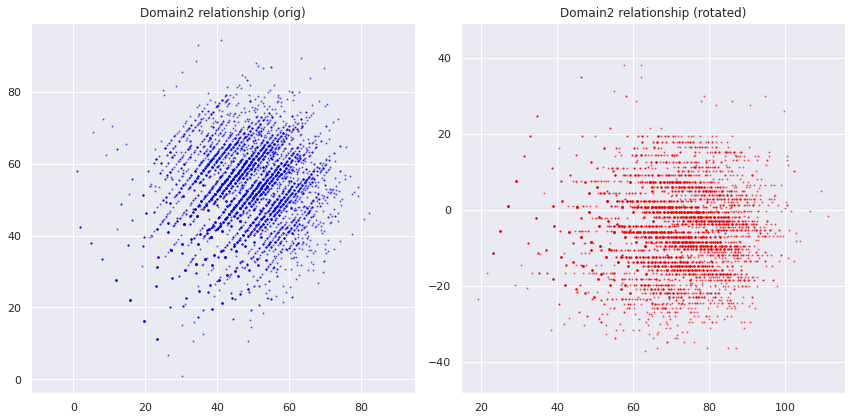

In [9]:
# Plot domain2 relationship with and without rotation
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].set_title('Domain2 relationship (orig)')
ax[0].scatter(y_tr_orig[:, 0], y_tr_orig[:, 1], s=1, alpha=0.5, c='b')
ax[0].axis('equal')

ax[1].set_title('Domain2 relationship (rotated)')
ax[1].scatter(y_tr_orig[:, 2], y_tr_orig[:, 3], s=1, alpha=0.5, c='r')
ax[1].axis('equal')

plt.tight_layout()
plt.show();

# 2. Define scoring functions for `domain2`

Now that the data is ready, let's prepare a simple scoring function that either focuses on `var1` or on `var2`.

In [10]:
class CustomLoss_focus(keras.losses.Loss):
    def __init__(self, scale=None, mean=None, focus=0, name="loss"):
        super().__init__(name=name + '_%d' % (focus + 1))
        self.scale = np.array(scale, dtype='float32')
        self.mean = np.array(mean, dtype='float32')
        self.focus = np.array(focus, dtype='int32')

    @tf.function
    def call(self, y_true, y_pred):

        # Rescale values
        y_true = tf.math.add(tf.math.multiply(self.scale, y_true), self.mean)
        y_pred = tf.math.add(tf.math.multiply(self.scale, y_pred), self.mean)

        # Revert power transformation
        y_true = tf.transpose(tf.stack([
            tf.math.pow(y_true[:, 0], 1./1.5),
            tf.math.pow(y_true[:, 1], 1./1.5)]))
        y_pred = tf.transpose(tf.stack([
            tf.math.pow(y_pred[:, 0], 1./1.5),
            tf.math.pow(y_pred[:, 1], 1./1.5)]))

        # Appli competition loss function
        scores = tf.math.divide(tf.math.reduce_sum(tf.math.abs(y_true - y_pred), axis=0),
                                tf.math.reduce_sum(tf.math.abs(y_true), axis=0))
        
        # Focus on var1 or var2
        score = scores[self.focus]

        return score

# 3. Define function to create NN model

The neural network has a rather simple architecture. It is a dense, fully connected neural network, with the potential for `BatchNormalization` and `Dropout` after every layer. The final output layer contains two output neurons with as many activation functions as loss functions.

The loss functions can be weighted to be between var1 and var2 with a hinge function, so that the wait for loss1 and loss2 always equals 1.

In [11]:
def build_model(input_size=100,
                activation='relu',
                dropout=0.5,
                kernel_initializer='glorot_uniform',
                lr=1e-2,
                use_batch=True,
                use_dropout=True,
                hidden=(32, 16),
                hinge=0.5,
               ):

    # Specify layer structure
    inputs = keras.Input(shape=input_size)
    
    for i, h in enumerate(hidden):
        if i==0:
            x = layers.Dense(h, kernel_initializer=kernel_initializer)(inputs)
        else:
            x = layers.Dense(h, kernel_initializer=kernel_initializer)(x)
        if use_batch:
            x = layers.BatchNormalization()(x)
        
        x = layers.Activation(activation)(x)

        # Add Dropout layer if requested
        if use_dropout:
            x = layers.Dropout(dropout)(x)

    out = layers.Dense(2)(x)
    out1 = layers.Activation(None, name="loss1")(out)
    out2 = layers.Activation(None, name="loss2")(out)

    # Create Model
    model = keras.Model(inputs, [out1, out2])

    # Define loss function, optimizer and metrics to track during training
    optimizer = keras.optimizers.Adagrad(
            learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                lr, decay_steps=10000, decay_rate=0.96, staircase=True))
    
    l1 = CustomLoss_focus(scale=scaler_targets.scale_[3:5],
                          mean=scaler_targets.mean_[3:5],
                          focus=0)
    l2 = CustomLoss_focus(scale=scaler_targets.scale_[3:5],
                          mean=scaler_targets.mean_[3:5],
                          focus=1)
    
    losses = {'loss1': l1, 'loss2': l2}
    lossWeights = {"loss1": hinge, "loss2": 1-hinge}

    model.compile(
        optimizer = optimizer,
        loss = losses,
        loss_weights = lossWeights
    )
    return model

# 4. Define parameter grid and function to run the grid (using KFold)

In [12]:
def create_grid(input_size=0):
    
    # Define parameter grid
    param_grid = [
    { 
        'nn__input_size': [input_size],
        'nn__lr': [0.05],
        'nn__activation': ['sigmoid'],
        'nn__hidden': [(128, 32),],
        'nn__dropout': [0.25],
        'nn__kernel_initializer': ['glorot_uniform'], #['glorot_uniform', 'normal', 'uniform'],
        'nn__use_batch': [True],
        'nn__use_dropout': [True],
        'nn__hinge': [0., 0.5, 1.],
        'batch_size': [32],
        'epochs': [50],
    }]
    
    # Create Parameter Grid and return it
    grids = ParameterGrid(param_grid)
    return grids

len(create_grid())

3

In [13]:
def run_grid(grid, X_tr, X_te, y_tr, cv=5, n=2):
    
    x_train = X_tr.copy()
    x_test = X_te.copy()
    print('Parameters:', grid)
        
    # Create callback object
    callbacks = [keras.callbacks.EarlyStopping(
        monitor="loss", min_delta=1e-5, patience=5, verbose=1)]

    # Build NN model
    nn_grid ={}
    for k in grid.keys():
        if 'nn__' in k:
            nn_grid[k[4:]] = grid[k]

    # Run NN fit on multiple folds
    history_runs = {'loss': [], 'val_loss': []}
    for i in range(n):
        history_runs['loss%d' % (i+1)] = []
        history_runs['val_loss%d' % (i+1)] = []

    kfold = KFold(n_splits=cv, shuffle=True)
    
    preds_cv_tr = []
    preds_cv_te = []
    counter = 0
    for train_idx, val_idx in kfold.split(x_train):
        
        # Prepare data for split
        x_train_k = x_train[train_idx]
        x_val_k = x_train[val_idx]

        y_train_k = y_tr[train_idx]
        y_val_k = y_tr[val_idx]

        # Prepare model
        model = build_model(**nn_grid)

        # Fit model
        history = model.fit(
            x_train_k,
            y_train_k,
            validation_data=(x_val_k, y_val_k),
            epochs=grid['epochs'],
            batch_size=grid['batch_size'],
            #callbacks=callbacks,
            shuffle=True, verbose=0
        )
        history_runs['loss'].append(history.history['loss'])
        history_runs['val_loss'].append(history.history['val_loss'])
        
        for i in range(n):
            history_runs['loss%d' % (i+1)].append(history.history['loss%d_loss' % (i+1)])
            history_runs['val_loss%d' % (i+1)].append(history.history['val_loss%d_loss' % (i+1)])
        
        # Compute predictions
        preds_cv_tr.append(model.predict(x_train)[0])
        preds_cv_te.append(model.predict(x_test)[0])
        
        # Report counter
        print('CV: %02d/%02d' % (counter+1, cv))
        counter += 1

    # Compute mean and standard deviation
    for l in [''] + [str(i+1) for i in range(n)]:
        history_runs['loss'+l+'_mean'] = pd.DataFrame(history_runs['loss'+l+'']).T.mean(axis=1).values
        history_runs['val_loss'+l+'_mean'] = pd.DataFrame(history_runs['val_loss'+l+'']).T.mean(axis=1).values
        history_runs['loss'+l+'_std'] = pd.DataFrame(history_runs['loss'+l+'']).T.std(axis=1).values
        history_runs['val_loss'+l+'_std'] = pd.DataFrame(history_runs['val_loss'+l+'']).T.std(axis=1).values
    
    # Collect mean and median predictions
    df_pred_mean_tr = pd.DataFrame(np.mean([e for e in preds_cv_tr if not np.isnan(e[0, 0])], axis=0), columns=['domain21', 'domain22'])
    df_pred_mean_te = pd.DataFrame(np.mean([e for e in preds_cv_te if not np.isnan(e[0, 0])], axis=0), columns=['domain21', 'domain22'])

    df_pred_median_tr = pd.DataFrame(np.median([e for e in preds_cv_tr if not np.isnan(e[0, 0])], axis=0), columns=['domain21', 'domain22'])
    df_pred_median_te = pd.DataFrame(np.median([e for e in preds_cv_te if not np.isnan(e[0, 0])], axis=0), columns=['domain21', 'domain22'])

    # Assign closest value from training set
    for tid in range(2):
        unique_values = np.unique(y_tr[:, tid])
        for d in [df_pred_mean_tr, df_pred_mean_te, df_pred_median_tr, df_pred_median_te]:
            for i in range(len(d)):
                d.iloc[i, tid] = unique_values[np.argmin(np.abs(d.iloc[i, tid]-unique_values))]

    return x_train, x_test, history_runs, model, df_pred_mean_tr, df_pred_mean_te, df_pred_median_tr, df_pred_median_te

In [14]:
def get_scores(y_tr, pred_tr, scaler=None, title=''):

    scores = []
    preds = []
    trues = []
    for i, tidx in enumerate([3, 4]):

        # Invert scaler
        t_true = scaler.inverse_transform(np.transpose([y_tr[:, i]] * 7))[:, tidx]
        t_pred = scaler.inverse_transform(np.transpose([pred_tr.iloc[:, i]] * 7))[:, tidx]

        # Invert power transformation
        t_true = np.power(t_true, 1./1.5)
        t_pred = np.power(t_pred, 1./1.5)

        # Compute the score
        score = np.mean(np.sum(np.abs(t_true - t_pred), axis=0) / np.sum(t_true, axis=0))
        scores.append(score)
        preds.append(t_pred)
        trues.append(t_true)

    scores = np.array(scores)
    preds = np.array(preds)
    trues = np.array(trues)

    pred_score = list(np.round(scores, 5))
    plt.figure(figsize=(6, 6))
    plt.title('Score on whole train set (var1, var2): ' + title + ' - ' + str(pred_score))
    print('Score on whole train set (var1, var2) %s: ' % title, pred_score)
    plt.scatter(trues[0], trues[1], s=0.5, alpha=0.5);
    plt.scatter(preds[0], preds[1], s=0.5, alpha=0.5);
    plt.axis('equal')

    plt.show()

# 5. Write a few supportive visualization functions

In [15]:
def plot_history_and_predictions(history, pred_tr, y_tr, cutoff=0, n=2):

    # Plot history results
    for l in [''] + [str(i+1) for i in range(n)]:
        fig = plt.figure(constrained_layout=True, figsize=(14, 3.5))
        plt.plot(history['loss'+l+'_mean'][cutoff:], label='train loss'+l)
        plt.plot(history['val_loss'+l+'_mean'][cutoff:], label='val loss'+l, linestyle='dotted')

        for m in ['loss'+l, 'val_loss'+l]:
            plt.fill_between(np.arange(len(history['%s_mean' % m][cutoff:])),
                             history['%s_mean' % m][cutoff:]-history['%s_std' % m][cutoff:],
                             history['%s_mean' % m][cutoff:]+history['%s_std' % m][cutoff:],
                             alpha=0.3)
        plt.title('Validation loss{}: {:.4f} (mean last 5)'.format(str(l),
            np.mean(history['val_loss'+l+'_mean'][-5:])
        ))
        plt.xlabel('epoch')
        plt.ylabel('loss'+l+' value')
        plt.legend()
        plt.show()

    # Categories
    categories = ['domain2_var1', 'domain2_var2']

    # Create subplot grid
    fig = plt.figure(constrained_layout=True, figsize=(9, 4))
    gs = fig.add_gridspec(1, 2)
    ax = [fig.add_subplot(gs[i]) for i in range(2)]

    # Plot discrepancy on training set
    for i, axt in enumerate(ax):
        sns.regplot(x=pred_tr[0][i, :], y=y_tr[:, i], marker='.', ax=axt,
                    scatter_kws={'alpha': 0.33, 's': 1})
        sns.regplot(x=pred_tr[1][i, :], y=y_tr[:, i], marker='.', ax=axt,
                    scatter_kws={'alpha': 0.33, 's': 1})
        axt.set_title('Prediction X_tr: %s' % categories[i])
        axt.set_xlim(-3, 3)
        axt.set_ylim(-3, 3)
        axt.legend(['Mean', 'Median'])
        axt.set_aspect('equal')

    plt.show()

In [16]:
def get_scores(y_tr, pred_tr, scaler=None):

    scores = []
    preds = []
    trues = []
    for j, tidx in enumerate([3, 4]):

        # Invert scaler
        t_true = scaler.inverse_transform(np.transpose([y_tr[:, j]] * 7))[:, tidx]
        t_pred = scaler.inverse_transform(np.transpose([pred_tr.iloc[:, j]] * 7))[:, tidx]

        # Invert power transformation
        t_true = np.power(t_true, 1./1.5)
        t_pred = np.power(t_pred, 1./1.5)

        # Compute the score
        score = np.mean(np.sum(np.abs(t_true - t_pred), axis=0) / np.sum(t_true, axis=0))
        scores.append(score)
        preds.append(t_pred)
        trues.append(t_true)

    return np.array(scores), np.array(preds), np.array(trues)

In [17]:
def plot_predictions_m(df_pred_mean_tr, df_pred_median_tr, y_tr, scaler=None):

    # Categories
    categories = ['mean', 'median']
    preds_m = [df_pred_mean_tr, df_pred_median_tr]

    # Create subplot grid
    fig = plt.figure(constrained_layout=True, figsize=(11, 5))
    gs = fig.add_gridspec(1, 2)
    ax = [fig.add_subplot(gs[i]) for i in range(2)]

    # Plot discrepancy on training set
    for i, axt in enumerate(ax):
        scores, preds, trues = get_scores(y_tr, preds_m[i], scaler=scaler)
        pred_score = list(np.round(scores, 5))
        axt.scatter(trues[0], trues[1], s=0.5, alpha=0.5);
        axt.scatter(preds[0], preds[1], s=0.5, alpha=0.5);
        axt.set_title('Score on whole train set (var1, var2):\n' + categories[i] + ' - ' + str(pred_score))
        axt.legend(['Target', 'Prediction'])
        axt.set_aspect('equal')

    plt.show()

In [18]:
def extract_score_info(history, n=2):
    tr_mean = np.round(np.mean(history['loss_mean'][-5:]), 6)
    te_mean = np.round(np.mean(history['val_loss_mean'][-5:]), 6)

    res = [tr_mean, te_mean]
    
    for i in range(n):
        res.append(np.round(np.mean(history['loss%d_mean' % (i+1)][-5:]), 6))
        res.append(np.round(np.mean(history['val_loss%d_mean' % (i+1)][-5:]), 6))

    return res

# 6. Dual `domain2` prediction based on MAE score

In [19]:
def run_prediction(dataset_id='merge', cv=5, n=2, scale_values=None):

    # Extract dataset
    X_tr, X_te, y_tr = load_dataset_and_scale(dataset_id, scale_values=scale_values)
    
    # Reduce target to number of outputs
    y_tr = y_tr[:, :2]

    # Create grid search object
    grids = create_grid(input_size=X_tr.shape[1])
    print('%0d grid points will be checked!' % len(grids))
    print('\n---Start_Grid_Exploration---\n')
 
    # Go through the grids
    preds_tr = []
    preds_te = []
    df_grids = []
    for gidx, grid in enumerate(tqdm(grids)):

        # Run grid
        print('\nGrid point: %04d/%04d' % (gidx + 1, len(grids)))
        x_train, x_test, history, model, df_pred_mean_tr, df_pred_mean_te, df_pred_median_tr, df_pred_median_te = run_grid(grid, X_tr, X_te, y_tr, cv=cv, n=n)

        # Compute predictions
        preds_tr.append([df_pred_mean_tr, df_pred_median_tr])
        preds_te.append([df_pred_mean_te, df_pred_median_te])

        # Plot history results and predictions
        plot_history_and_predictions(history, [df_pred_mean_tr.T.values,df_pred_median_tr.T.values], y_tr, cutoff=0, n=n)
        plot_predictions_m(df_pred_mean_tr, df_pred_median_tr, y_tr, scaler=scaler_targets)
        
        # Extract scores
        score_means = extract_score_info(history, n=n)

        # Store everything in a grid
        df_grid = pd.DataFrame(columns=grid.keys())
        for k in grid:
            df_grid.loc[0, k] = str(grid[k])
        df_grid.insert(0, 'tr_mean', score_means[0])
        df_grid.insert(1, 'te_mean', score_means[1])
        for i in range(n):
            df_grid.insert(2+(i*2), 'tr_mean%d' % (i+1), score_means[2+(i*2)])
            df_grid.insert(3+(i*2), 'te_mean%d' % (i+1), score_means[3+(i*2)])
        df_grids.append(df_grid)

    # Summarize fit in datatable
    df_fit = pd.concat(df_grids).reset_index().drop(columns='index')
    display(df_fit)
    
    return preds_tr, preds_te, df_fit.iloc[0], df_grid, y_tr, history

Removing 39 missing values from target dataset.
Size of dataset (train/test):  (5796, 2835) (5877, 2835)
3 grid points will be checked!

---Start_Grid_Exploration---




Grid point: 0001/0003
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 0.0, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


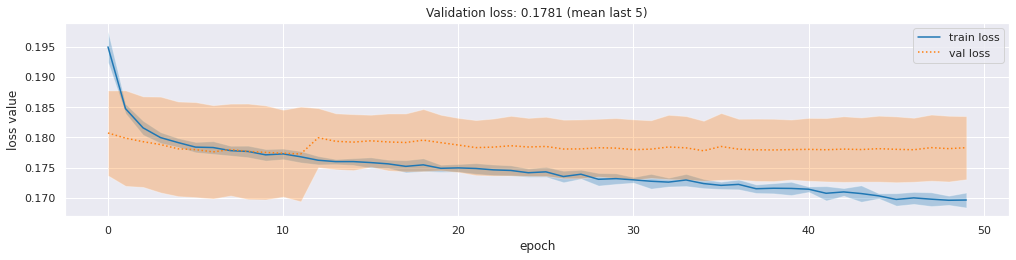

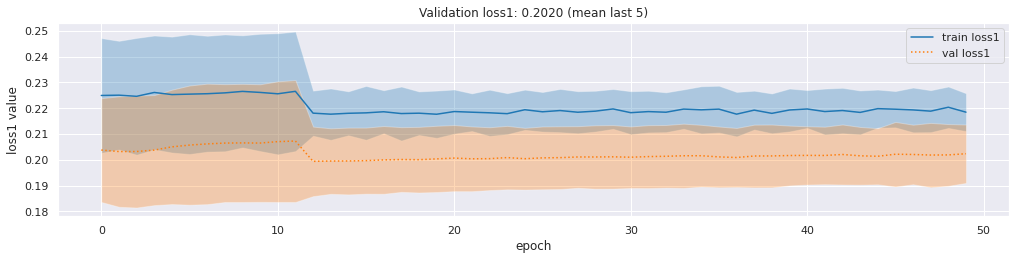

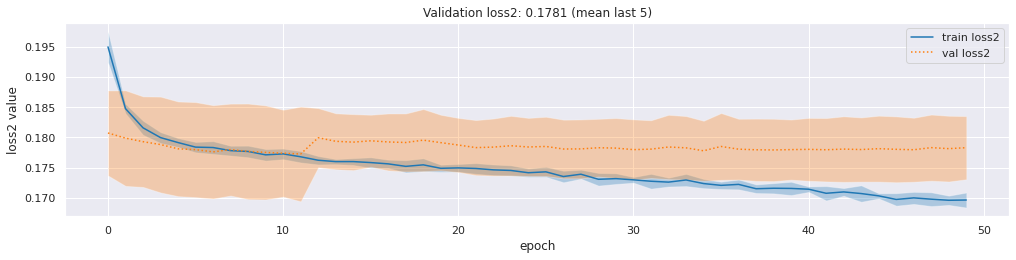

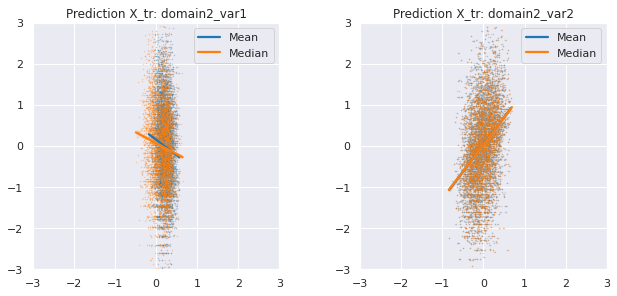

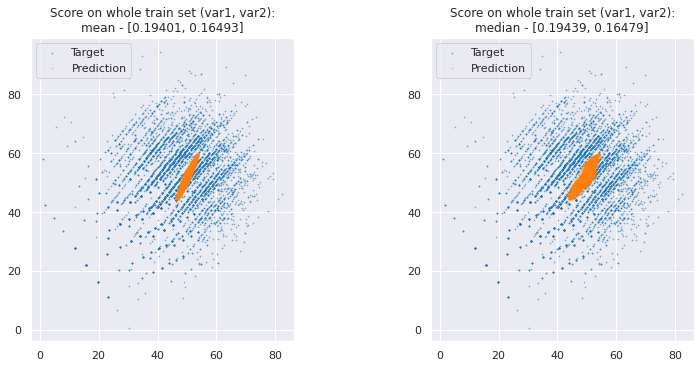


Grid point: 0002/0003
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 0.5, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


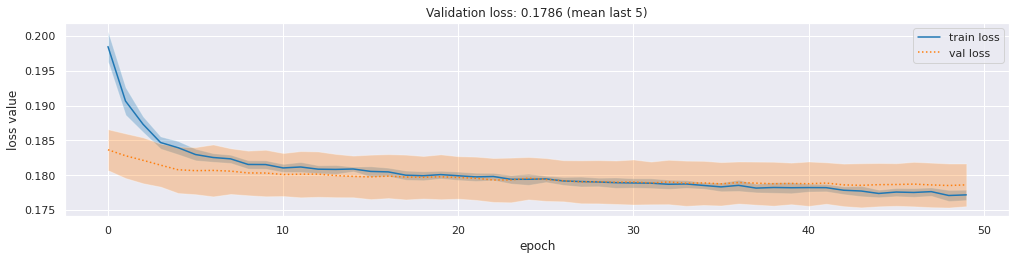

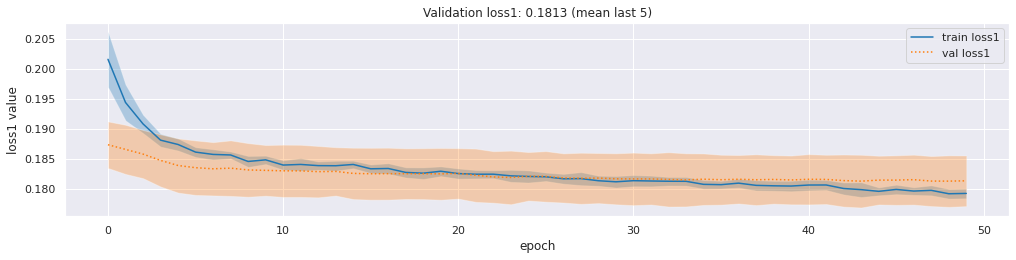

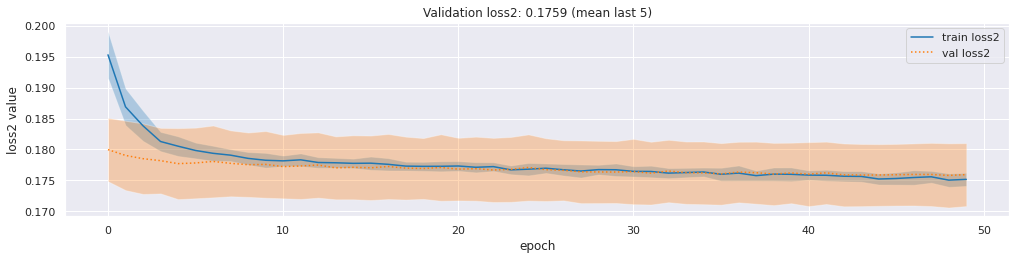

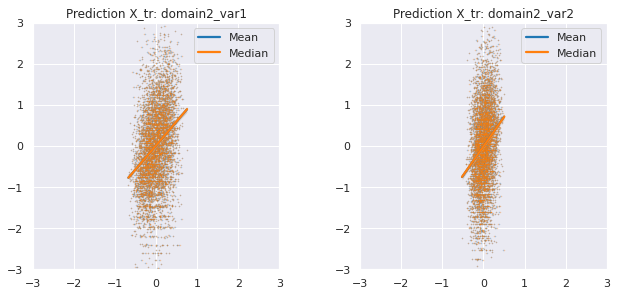

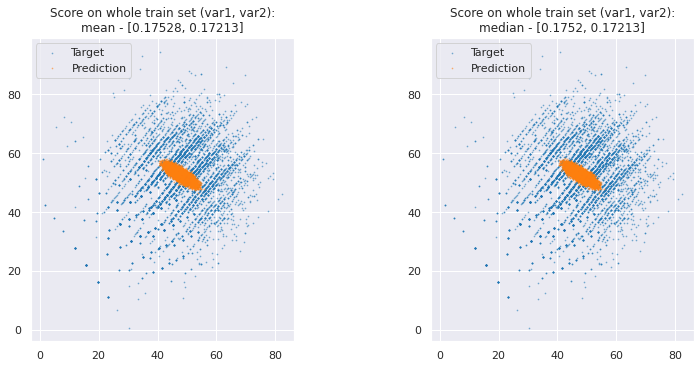


Grid point: 0003/0003
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 1.0, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


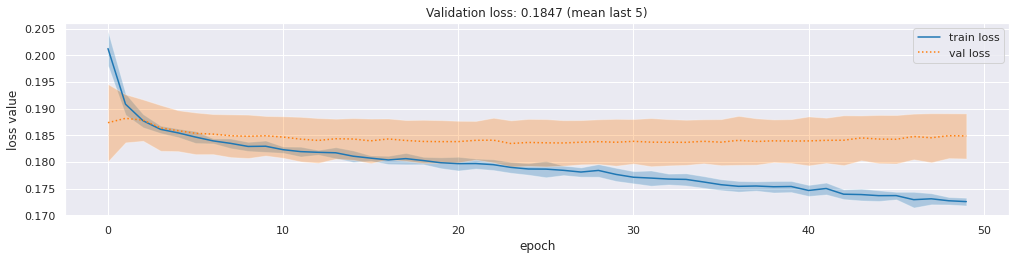

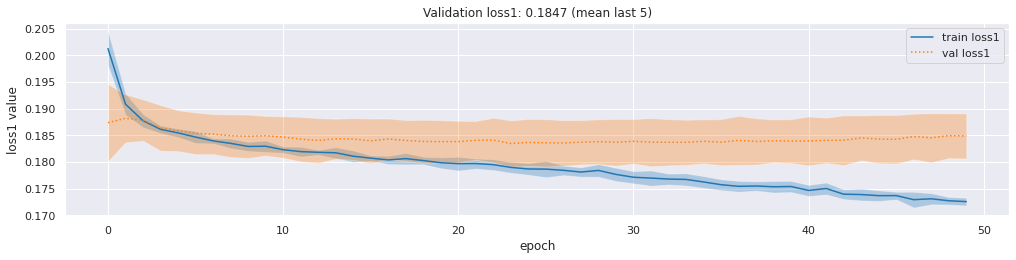

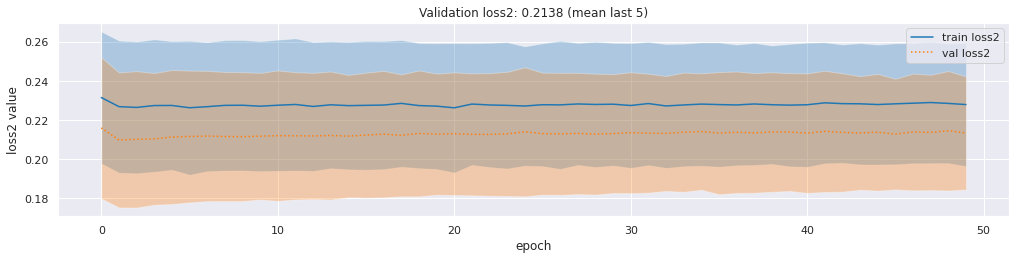

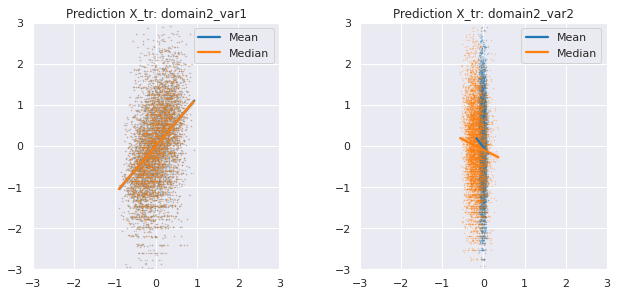

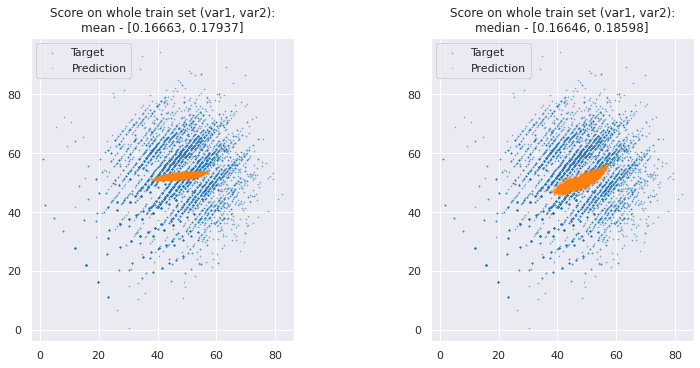

tr_mean   te_mean  tr_mean1  te_mean1  tr_mean2  te_mean2 batch_size  \
0  0.169737  0.178143  0.219295  0.202031  0.169737  0.178143         32   
1  0.177393  0.178617  0.179491  0.181337  0.175295  0.175897         32   
2  0.172985  0.184669  0.172985  0.184669  0.228562  0.213755         32   

  epochs nn__activation nn__dropout nn__hidden nn__hinge nn__input_size  \
0     50        sigmoid        0.25  (128, 32)       0.0           2835   
1     50        sigmoid        0.25  (128, 32)       0.5           2835   
2     50        sigmoid        0.25  (128, 32)       1.0           2835   

  nn__kernel_initializer nn__lr nn__use_batch nn__use_dropout  
0         glorot_uniform   0.05          True            True  
1         glorot_uniform   0.05          True            True  
2         glorot_uniform   0.05          True            True

Best score at 0.178143 / 0.169737


In [20]:
# Define feature set scales (~average from my second notebook)
scale_values = [0.25, 0.025, 0.04, 0.02]

# Run model fit
preds_tr, preds_te, top_grid, df_grid, y_tr, history = run_prediction(cv=8, n=2, scale_values=scale_values)

# Feedback of overall score
print('Best score at %s / %s' % (top_grid['te_mean'], top_grid['tr_mean']))

## Observation 1

Depending on the focus (i.e. focus on `var1` or `var2`, the prediction is spreading into the direction of the component and ignoring the other. A simultaneous fitting doesn't seem to improve the prediction quality, it only helps to reduce standard deviation between the folds.

Also, the network clearly starts to overfit and the standard deviation between the different folds is rather big. No reasonable improvement in prediction score can be achieved in such a way.

# 7. Dual `domain2` prediction based on distance metric

The thought here is the following. What we try to minmize is the distance between a predicted point and the target point, where x and y coordinates are the var1 and var2 values. The hope was, that by including the rotated distance metric as well, the prediction of the original values would improve. Because only if the prediction (i.e. the x and y coordinates) are close enough, the rotation makes sense.

In [21]:
class CustomLoss_dist(keras.losses.Loss):
    def __init__(self, name="loss"):
        super().__init__(name=name)

    @tf.function
    def call(self, y_true, y_pred):

        # Compute distance to target
        score = tf.math.pow(tf.reduce_mean(tf.math.pow(tf.norm(tf.math.subtract(y_true, y_pred), axis=1), 3.)), 1./3.)
        
        return score

In [22]:
class CustomLoss_dist_rot(keras.losses.Loss):
    def __init__(self, scale=None, mean=None, name="loss_rot"):
        super().__init__(name=name)
        self.scale = np.array(scale, dtype='float32')
        self.mean = np.array(mean, dtype='float32')

    @tf.function
    def call(self, y_true, y_pred):

        # Rescale values
        y_true = tf.math.add(tf.math.multiply(self.scale[:2], y_true), self.mean[:2])
        y_pred = tf.math.add(tf.math.multiply(self.scale[:2], y_pred), self.mean[:2])

        # Revert power transformation
        y_true = tf.transpose(tf.stack([
            tf.math.pow(y_true[:, 0], 1./1.5),
            tf.math.pow(y_true[:, 1], 1./1.5)]))
        y_pred = tf.transpose(tf.stack([
            tf.math.pow(y_pred[:, 0], 1./1.5),
            tf.math.pow(y_pred[:, 1], 1./1.5)]))

        # Apply rotation for true and preds
        d2_rot = 0.90771256655
        radians = tf.constant(d2_rot, dtype='float32')
        yt_rot = tf.transpose(tf.stack([
            tf.math.add(tf.math.multiply(y_true[:, 0], [tf.cos(radians)]),
                        tf.math.multiply(y_true[:, 1], [tf.sin(radians)])),
            tf.math.add(-tf.math.multiply(y_true[:, 0], [tf.sin(radians)]),
                        tf.math.multiply(y_true[:, 1], [tf.cos(radians)]))
        ]))
        yp_rot = tf.transpose(tf.stack([
            tf.math.add(tf.math.multiply(y_pred[:, 0], [tf.cos(radians)]),
                        tf.math.multiply(y_pred[:, 1], [tf.sin(radians)])),
            tf.math.add(-tf.math.multiply(y_pred[:, 0], [tf.sin(radians)]),
                        tf.math.multiply(y_pred[:, 1], [tf.cos(radians)]))
        ]))        

        # Rescale values
        yt_rot = tf.math.divide(tf.math.subtract(yt_rot, self.mean[2:]), self.scale[2:])
        yp_rot = tf.math.divide(tf.math.subtract(yp_rot, self.mean[2:]), self.scale[2:])
                
        # Compute distance to target
        score_dist = tf.math.pow(tf.reduce_mean(tf.math.pow(tf.norm(tf.math.subtract(yt_rot, yp_rot), axis=1), 3.)), 1./3.)

        return score_dist

In [23]:
def build_model(input_size=100,
                activation='relu',
                dropout=0.5,
                kernel_initializer='glorot_uniform',
                lr=1e-2,
                use_batch=True,
                use_dropout=True,
                hidden=(32, 16),
                hinge_dist=0.5,
               ):

    # Specify layer structure
    inputs = keras.Input(shape=input_size)
    
    for i, h in enumerate(hidden):
        if i==0:
            x = layers.Dense(h, kernel_initializer=kernel_initializer)(inputs)
        else:
            x = layers.Dense(h, kernel_initializer=kernel_initializer)(x)
        if use_batch:
            x = layers.BatchNormalization()(x)
        
        x = layers.Activation(activation)(x)

        # Add Dropout layer if requested
        if use_dropout:
            x = layers.Dropout(dropout)(x)

    out = layers.Dense(2)(x)
    out1 = layers.Activation(None, name="loss1")(out)
    out2 = layers.Activation(None, name="loss2")(out)

    # Create Model
    model = keras.Model(inputs, [out1, out2])
    
    # Define loss function, optimizer and metrics to track during training
    optimizer = keras.optimizers.Adagrad(
            learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                lr, decay_steps=10000, decay_rate=0.96, staircase=True))
    
    l1 = CustomLoss_dist()
    l2 = CustomLoss_dist_rot(scale=scaler_targets.scale_[3:],
                             mean=scaler_targets.mean_[3:])
    
    losses = {'loss1': l1, 'loss2': l2}
    lossWeights = {"loss1": hinge_dist, "loss2": 1-hinge_dist}

    model.compile(
        optimizer = optimizer,
        loss = losses,
        loss_weights = lossWeights
    )
    return model

In [24]:
def create_grid(input_size=0):
    
    # Define parameter grid
    param_grid = [
    { 
        'nn__input_size': [input_size],
        'nn__lr': [0.05],
        'nn__activation': ['sigmoid'],
        'nn__hidden': [(128, 32),],
        'nn__dropout': [0.25],
        'nn__kernel_initializer': ['glorot_uniform'], #['glorot_uniform', 'normal', 'uniform'],
        'nn__use_batch': [True],
        'nn__use_dropout': [True],
        'nn__hinge_dist': [0., 0.5, 1.],
        'batch_size': [32],
        'epochs': [50],
    }]
    
    # Create Parameter Grid and return it
    grids = ParameterGrid(param_grid)
    return grids

len(create_grid())

3

Removing 39 missing values from target dataset.
Size of dataset (train/test):  (5796, 2835) (5877, 2835)
3 grid points will be checked!

---Start_Grid_Exploration---




Grid point: 0001/0003
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge_dist': 0.0, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


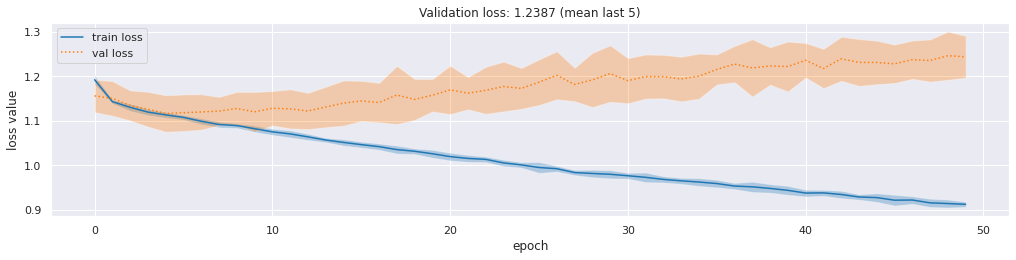

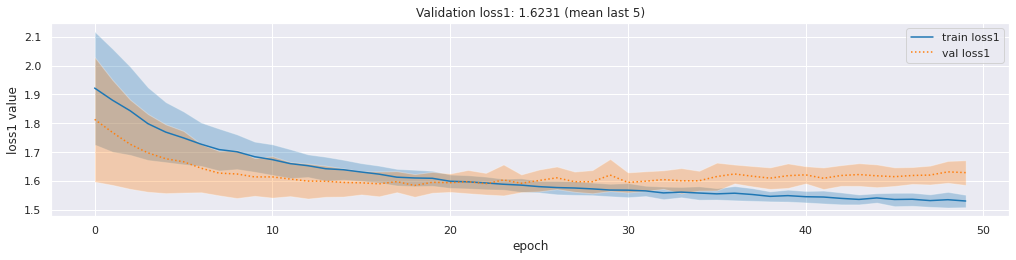

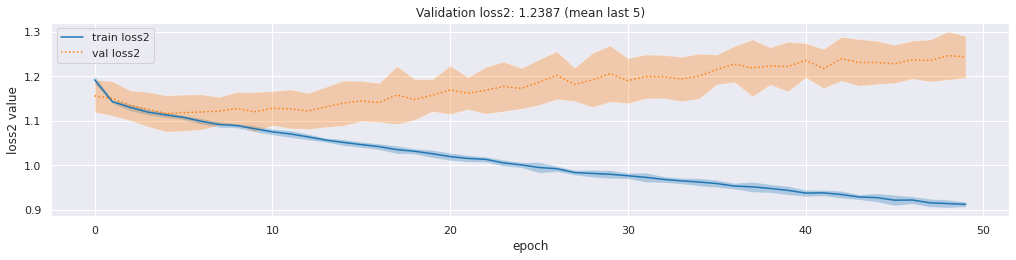

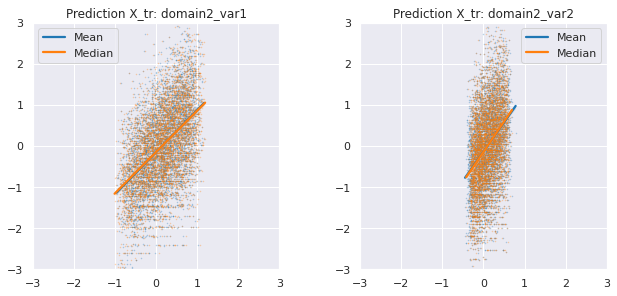

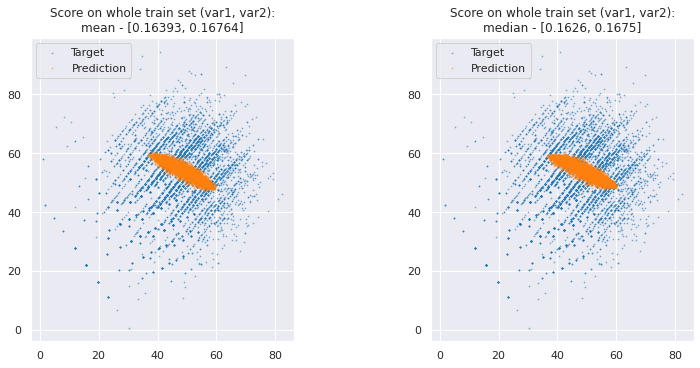


Grid point: 0002/0003
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge_dist': 0.5, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


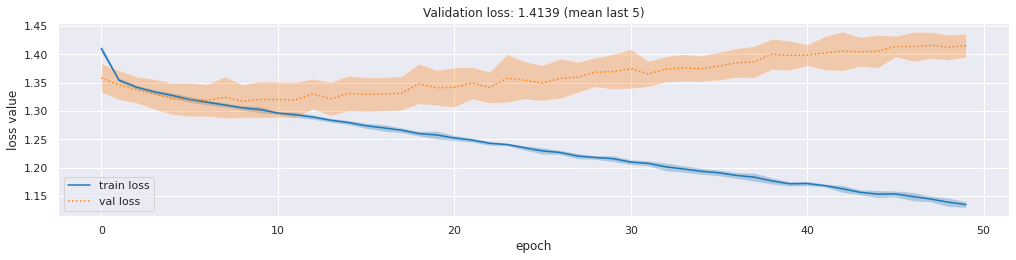

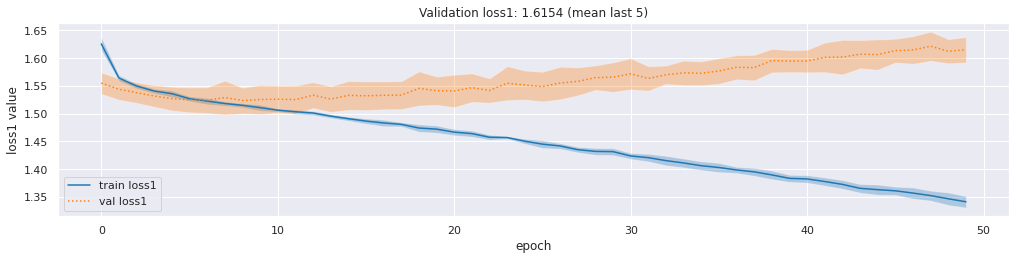

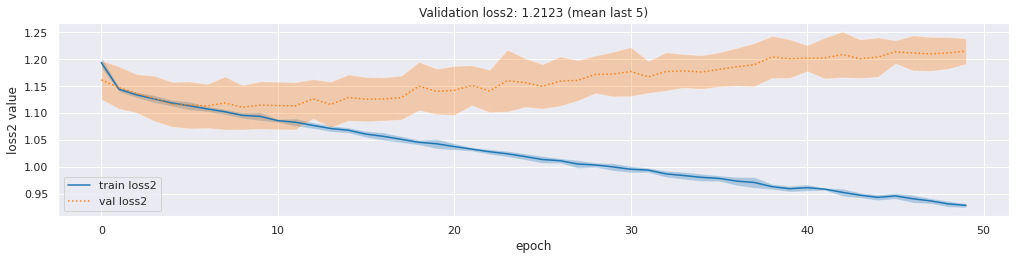

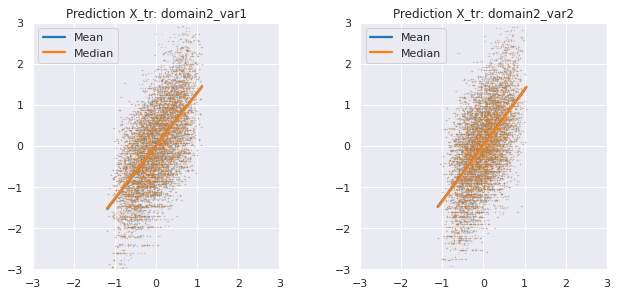

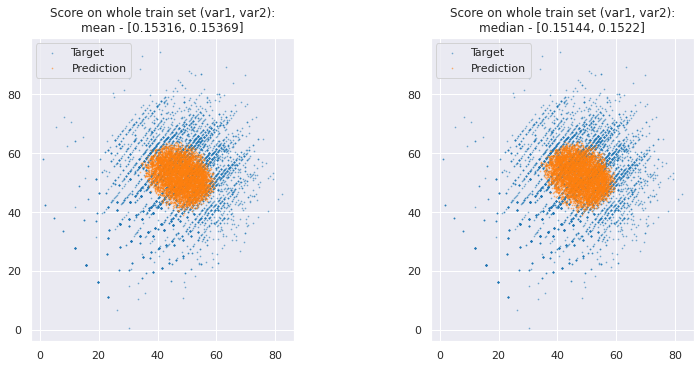


Grid point: 0003/0003
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge_dist': 1.0, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


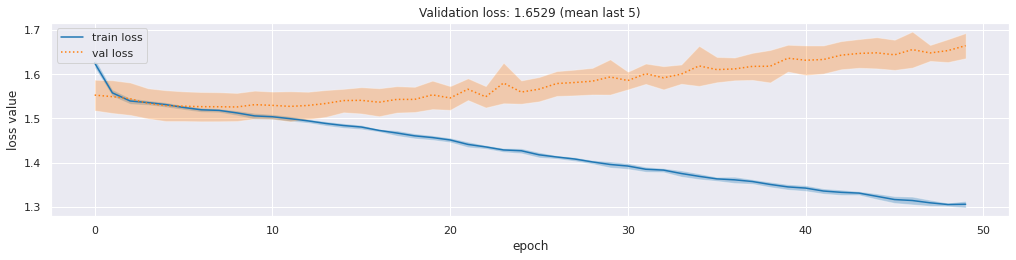

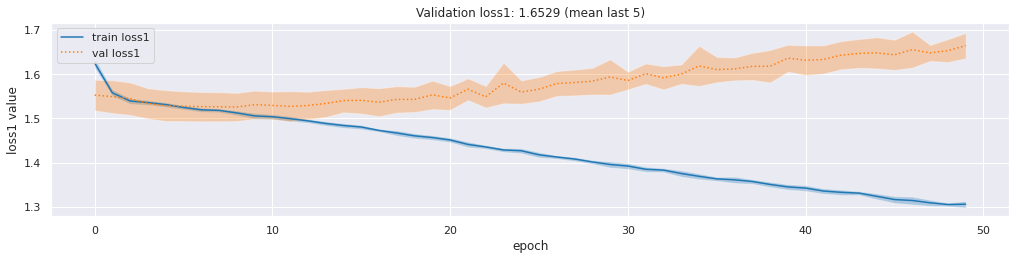

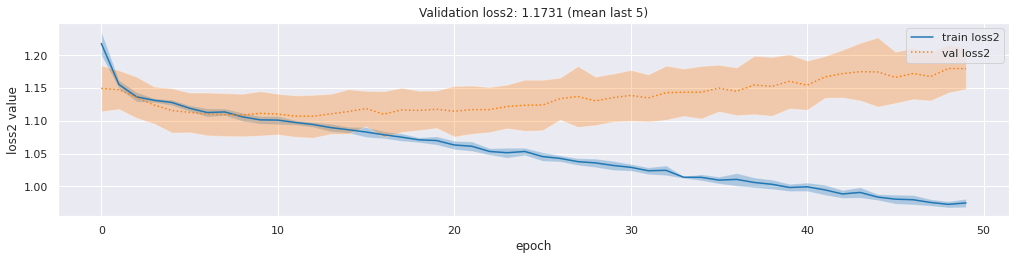

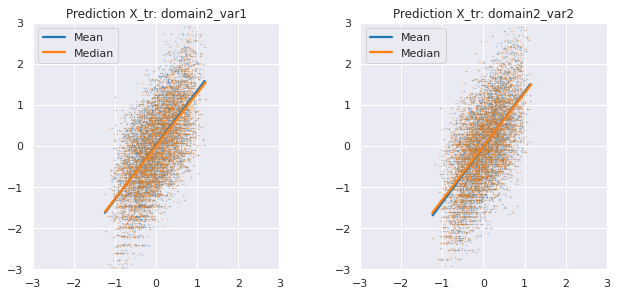

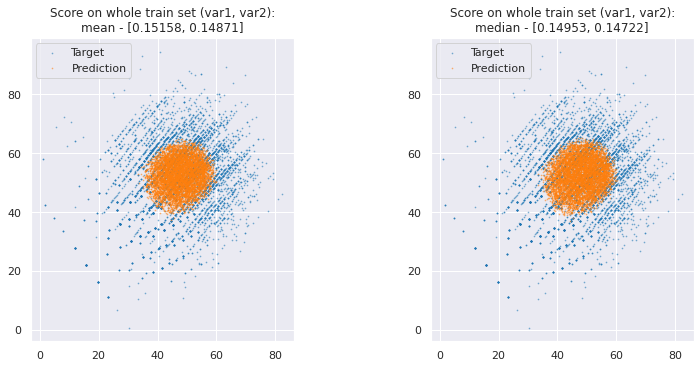

tr_mean   te_mean  tr_mean1  te_mean1  tr_mean2  te_mean2 batch_size  \
0  0.916710  1.238686  1.534127  1.623077   0.91671  1.238686         32   
1  1.144311  1.413861  1.351631  1.615426   0.93699  1.212297         32   
2  1.310181  1.652857  1.310181  1.652857   0.97666  1.173077         32   

  epochs nn__activation nn__dropout nn__hidden nn__hinge_dist nn__input_size  \
0     50        sigmoid        0.25  (128, 32)            0.0           2835   
1     50        sigmoid        0.25  (128, 32)            0.5           2835   
2     50        sigmoid        0.25  (128, 32)            1.0           2835   

  nn__kernel_initializer nn__lr nn__use_batch nn__use_dropout  
0         glorot_uniform   0.05          True            True  
1         glorot_uniform   0.05          True            True  
2         glorot_uniform   0.05          True            True

Best score at 1.238686 / 0.91671


In [25]:
# Define feature set scales (~average from my second notebook)
scale_values = [0.25, 0.025, 0.04, 0.02]

# Run model fit
preds_tr, preds_te, top_grid, df_grid, y_tr, history = run_prediction(cv=8, n=2, scale_values=scale_values)

# Feedback of overall score
print('Best score at %s / %s' % (top_grid['te_mean'], top_grid['tr_mean']))

## Observation 2

This approach doesn't really seem to work. While it stretches the prediction into something that is orthogonal to the orientation of `domain2_var2_rotated`, in the `hinge=0` condition, it creates only round blobs in the others.

# 8. Dual `domain2` prediction based on MAE and distance metric

The hope was, by combining the MAE and distance metric loss functions, we can restrict the predictions to its optimal place. However, this didn't really seem to work.

In [26]:
def build_model(input_size=100,
                activation='relu',
                dropout=0.5,
                kernel_initializer='glorot_uniform',
                lr=1e-2,
                use_batch=True,
                use_dropout=True,
                hidden=(32, 16),
                hinge=0.5,
                hinge_dist=0.5,
               ):

    # Specify layer structure
    inputs = keras.Input(shape=input_size)
    
    for i, h in enumerate(hidden):
        if i==0:
            x = layers.Dense(h, kernel_initializer=kernel_initializer)(inputs)
        else:
            x = layers.Dense(h, kernel_initializer=kernel_initializer)(x)
        if use_batch:
            x = layers.BatchNormalization()(x)
        
        x = layers.Activation(activation)(x)

        # Add Dropout layer if requested
        if use_dropout:
            x = layers.Dropout(dropout)(x)

    out = layers.Dense(2)(x)
    out1 = layers.Activation(None, name="loss1")(out)
    out2 = layers.Activation(None, name="loss2")(out)
    out3 = layers.Activation(None, name="loss3")(out)
    out4 = layers.Activation(None, name="loss4")(out)

    # Create Model
    model = keras.Model(inputs, [out1, out2, out3, out4])

    # Define loss function, optimizer and metrics to track during training
    optimizer = keras.optimizers.Adagrad(
            learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                lr, decay_steps=10000, decay_rate=0.96, staircase=True))
    
    l1 = CustomLoss_focus(scale=scaler_targets.scale_[3:5],
                          mean=scaler_targets.mean_[3:5],
                          focus=0)
    l2 = CustomLoss_focus(scale=scaler_targets.scale_[3:5],
                          mean=scaler_targets.mean_[3:5],
                          focus=1)
    l3 = CustomLoss_dist()
    l4 = CustomLoss_dist_rot(scale=scaler_targets.scale_[3:],
                             mean=scaler_targets.mean_[3:])
    
    losses = {'loss1': l1, 'loss2': l2, 'loss3': l3, 'loss4': l4}
    adjustment_factor = 1./10.
    lossWeights = {"loss1": hinge,
                   "loss2": 1-hinge,
                   "loss3": (hinge_dist)*adjustment_factor,
                   "loss4": (1-hinge_dist)*adjustment_factor}

    model.compile(
        optimizer = optimizer,
        loss = losses,
        loss_weights = lossWeights
    )
    return model

In [27]:
def create_grid(input_size=0):
    
    # Define parameter grid
    param_grid = [
    { 
        'nn__input_size': [input_size],
        'nn__lr': [0.05],
        'nn__activation': ['sigmoid'],
        'nn__hidden': [(128, 32),],
        'nn__dropout': [0.25],
        'nn__kernel_initializer': ['glorot_uniform'], #['glorot_uniform', 'normal', 'uniform'],
        'nn__use_batch': [True],
        'nn__use_dropout': [True],
        'nn__hinge': [0., 0.5, 1.],
        'nn__hinge_dist': [0., 0.5, 1.],
        'batch_size': [32],
        'epochs': [50],
    }]
    
    # Create Parameter Grid and return it
    grids = ParameterGrid(param_grid)
    return grids

len(create_grid())

9

Removing 39 missing values from target dataset.
Size of dataset (train/test):  (5796, 2835) (5877, 2835)
9 grid points will be checked!

---Start_Grid_Exploration---




Grid point: 0001/0009
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 0.0, 'nn__hinge_dist': 0.0, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


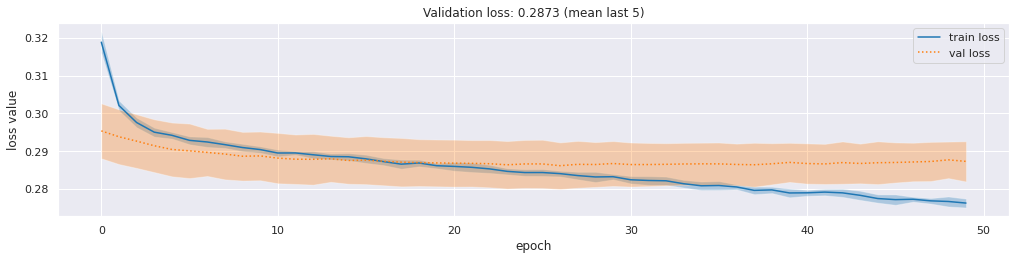

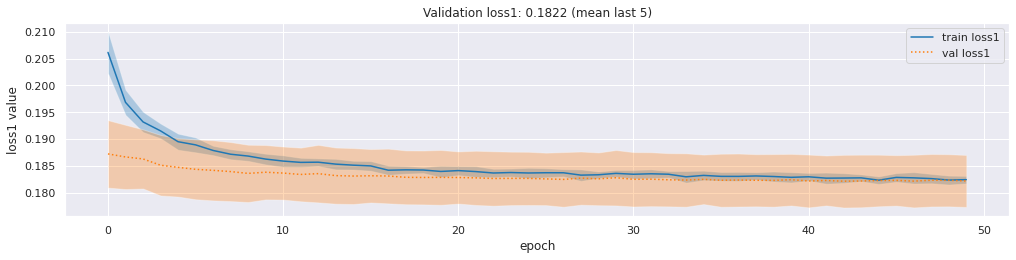

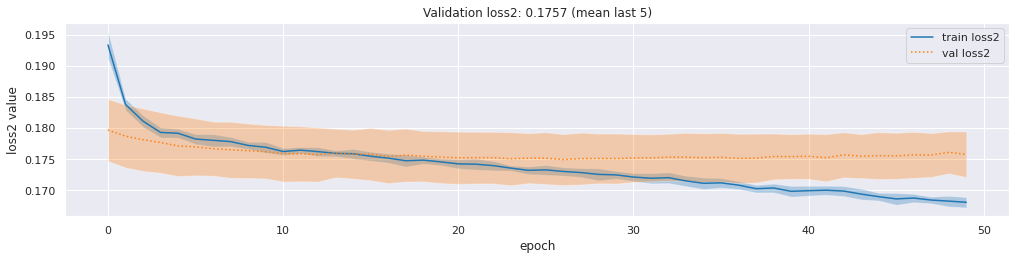

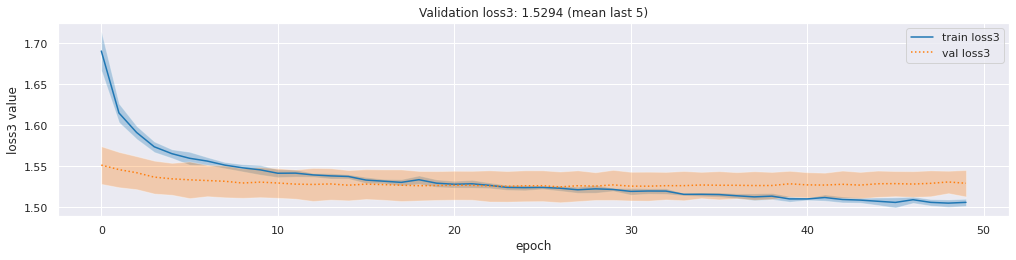

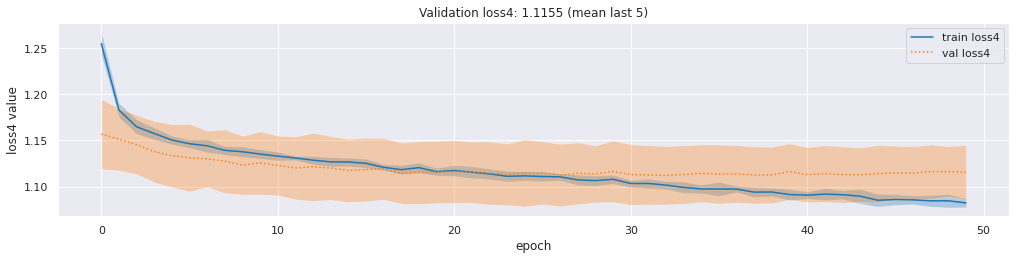

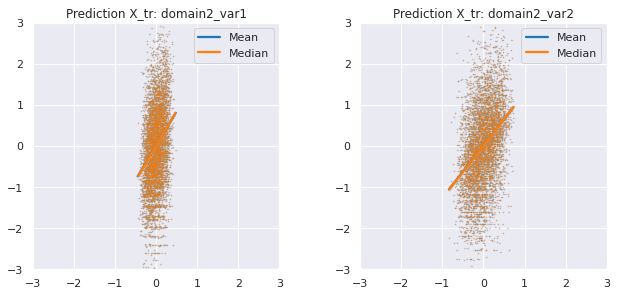

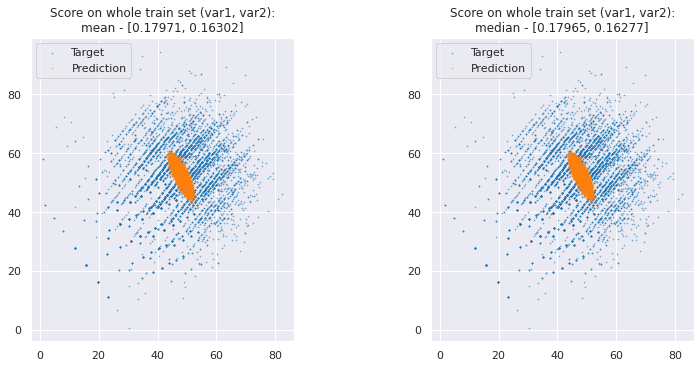


Grid point: 0002/0009
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 0.0, 'nn__hinge_dist': 0.5, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


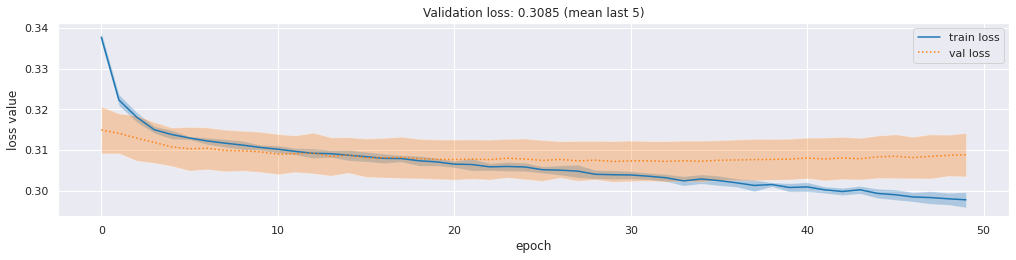

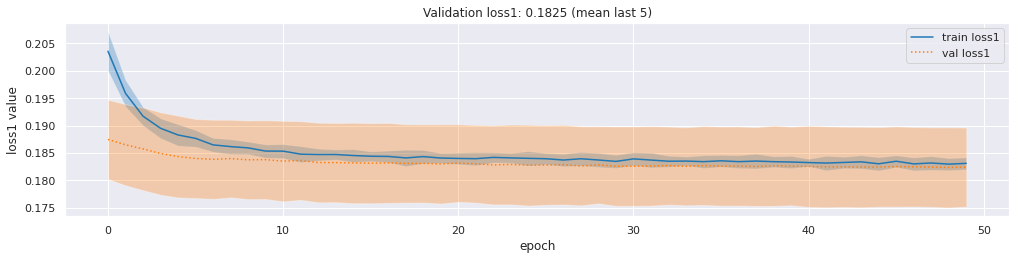

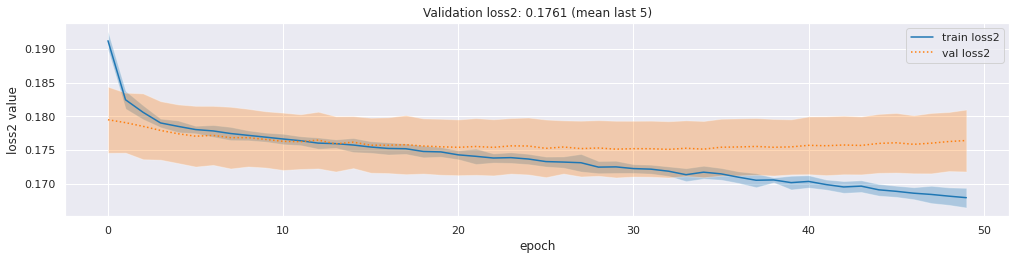

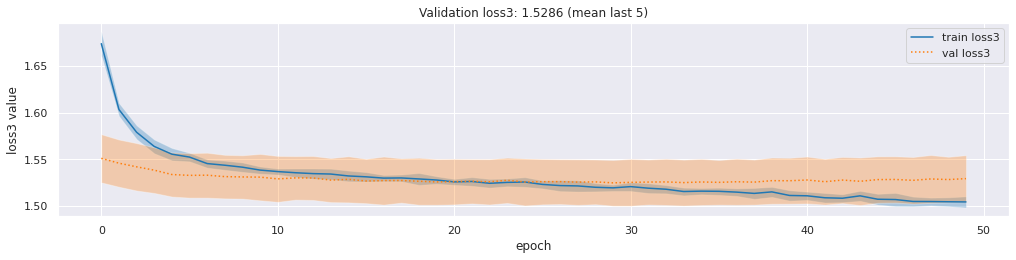

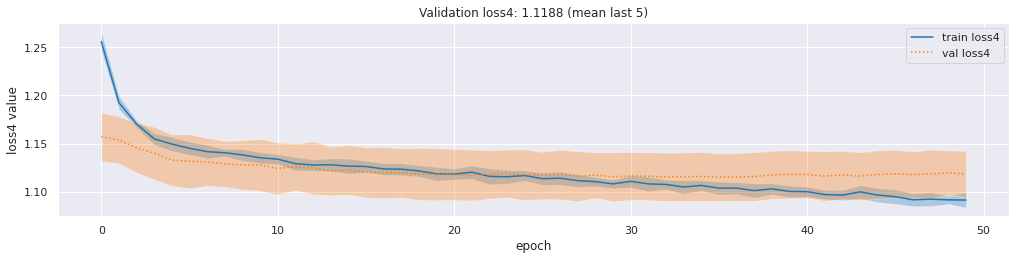

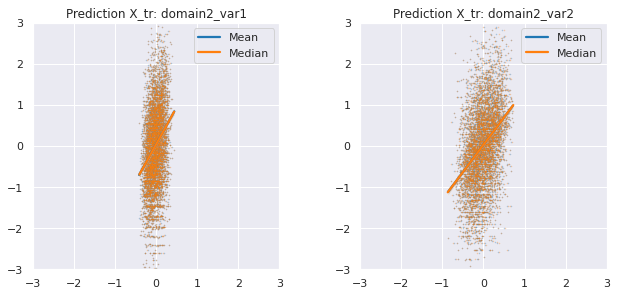

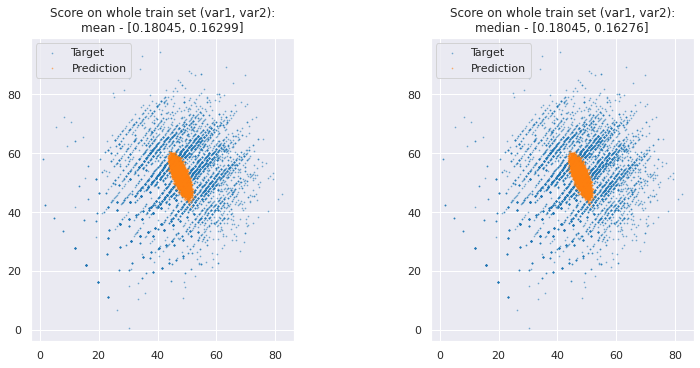


Grid point: 0003/0009
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 0.0, 'nn__hinge_dist': 1.0, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


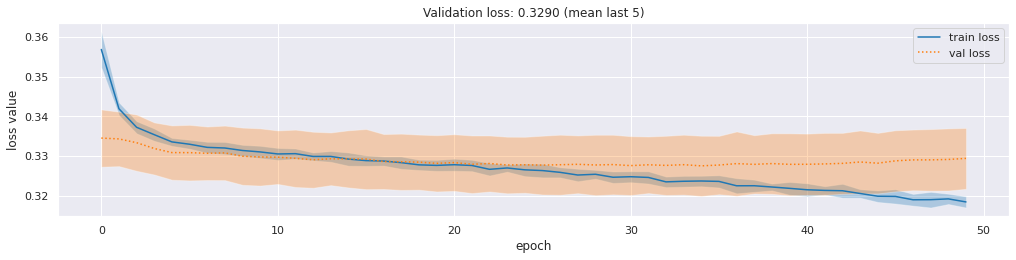

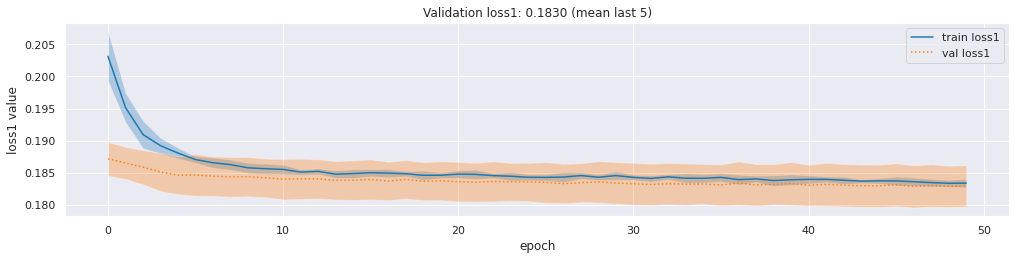

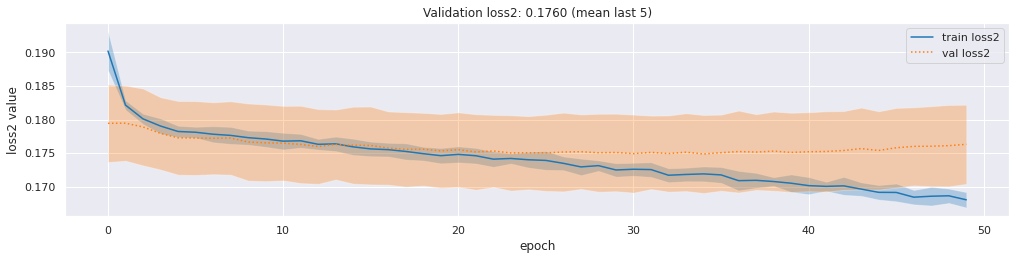

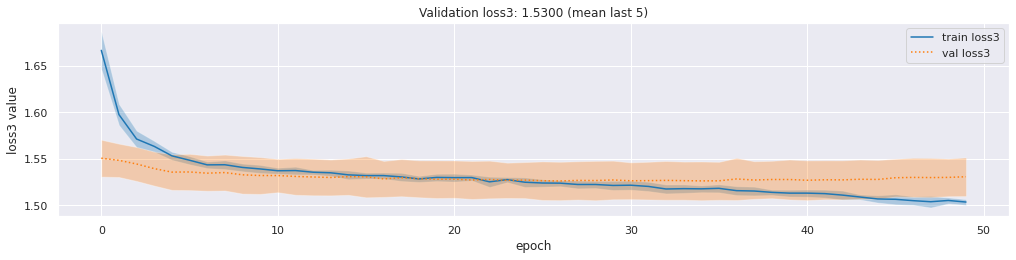

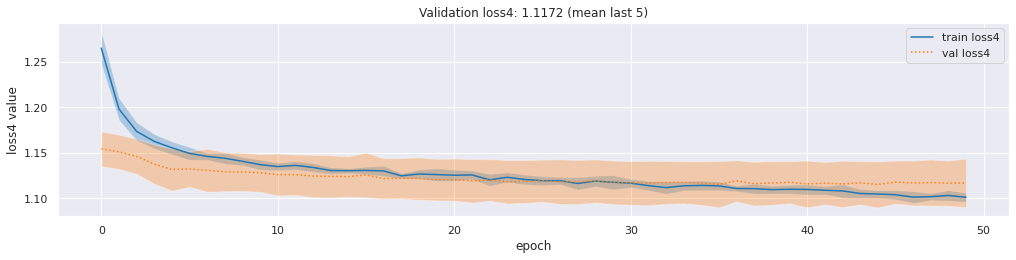

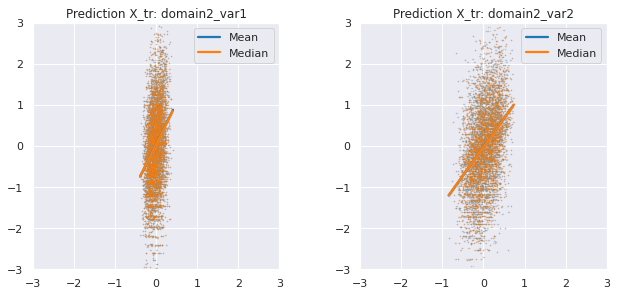

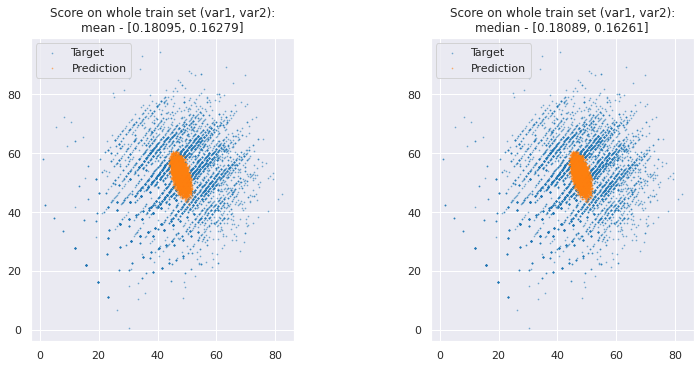


Grid point: 0004/0009
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 0.5, 'nn__hinge_dist': 0.0, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


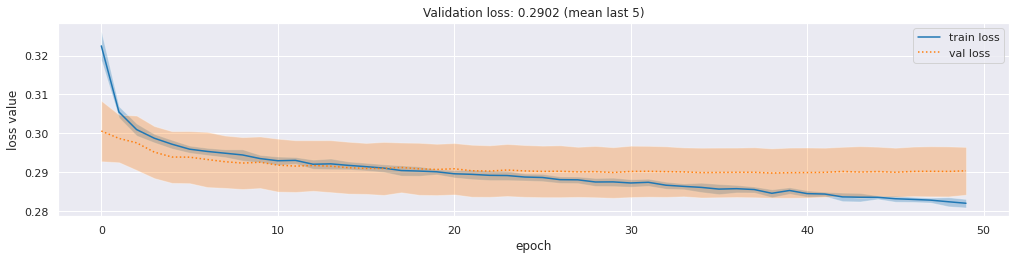

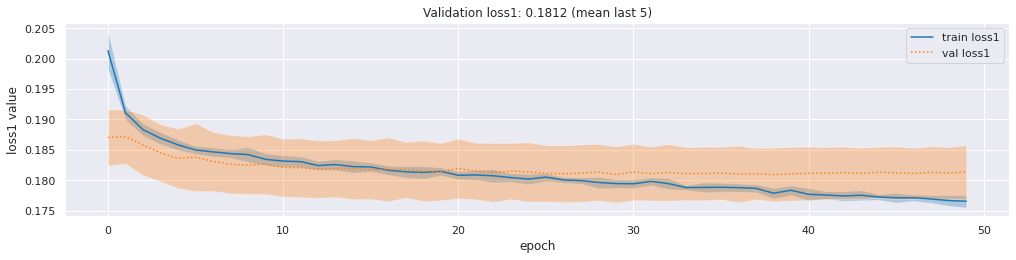

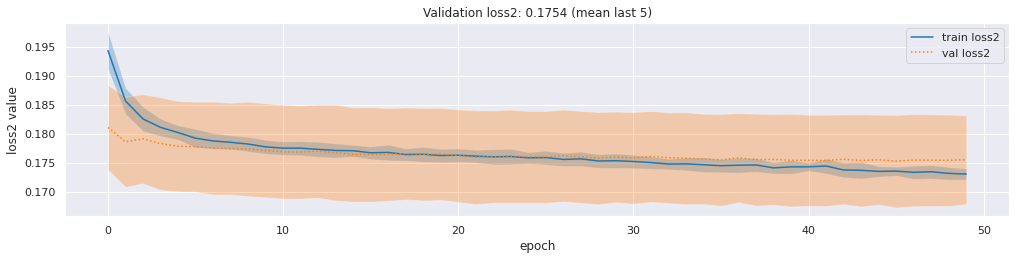

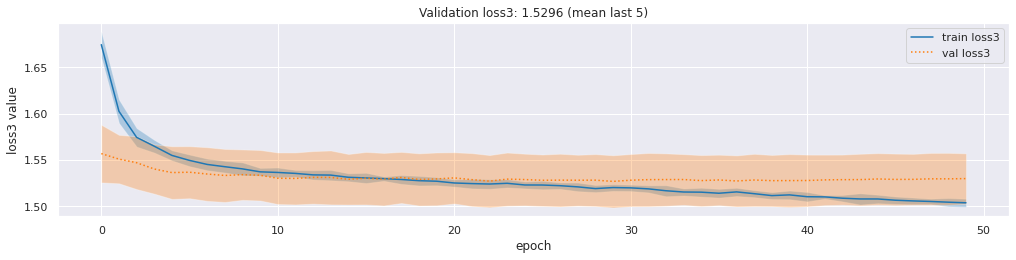

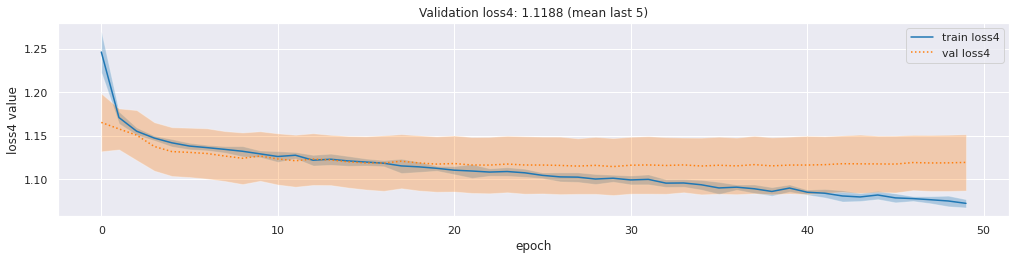

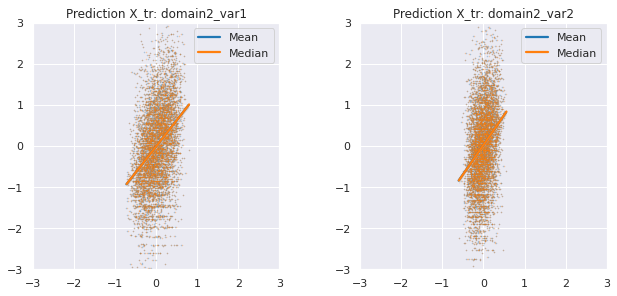

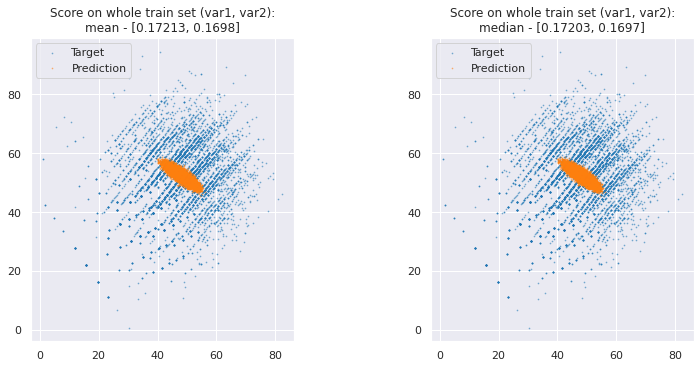


Grid point: 0005/0009
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 0.5, 'nn__hinge_dist': 0.5, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


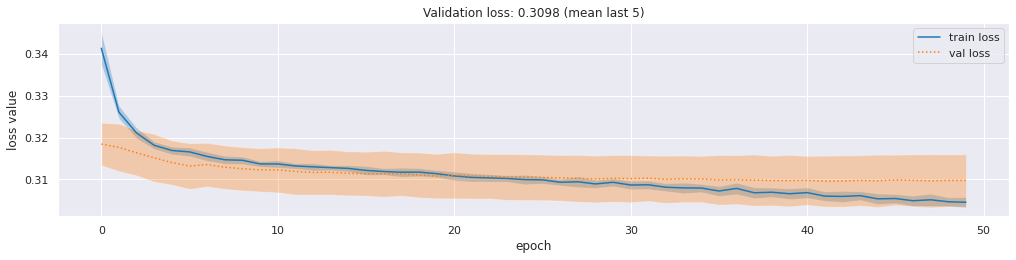

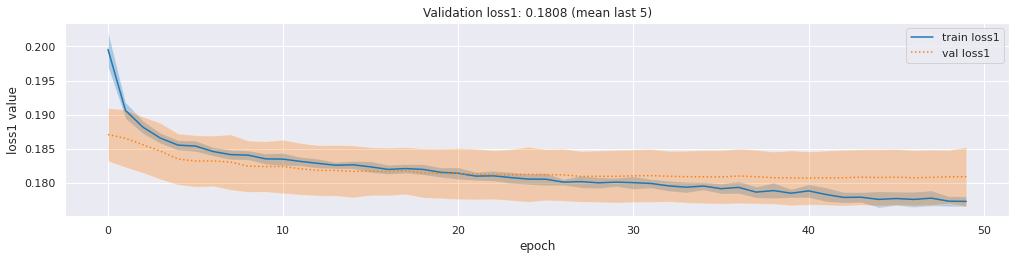

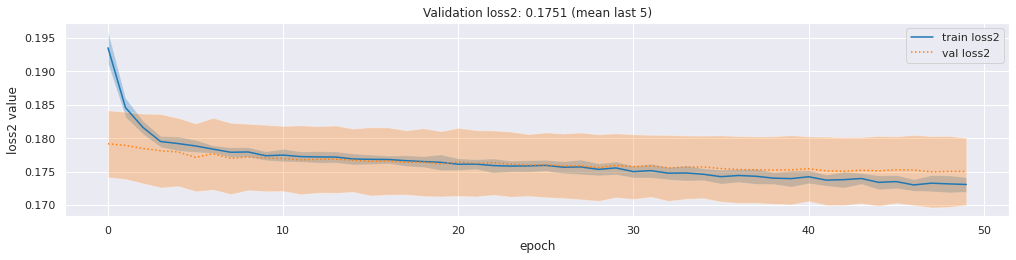

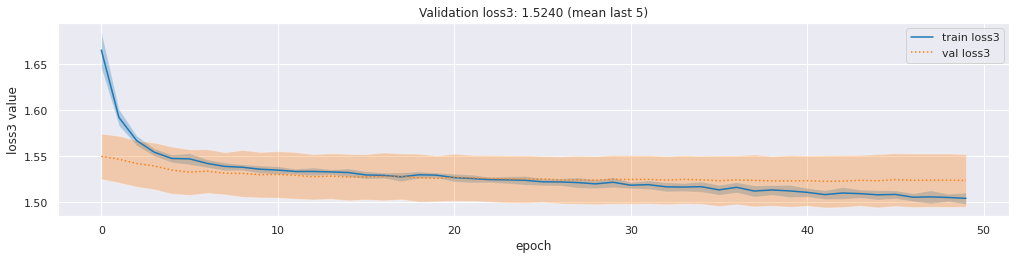

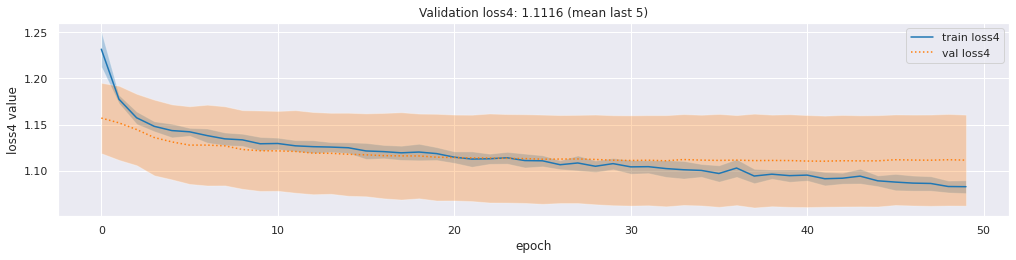

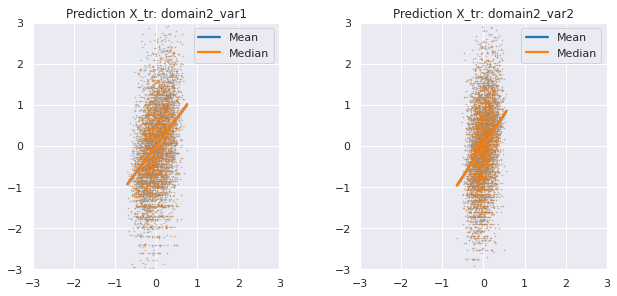

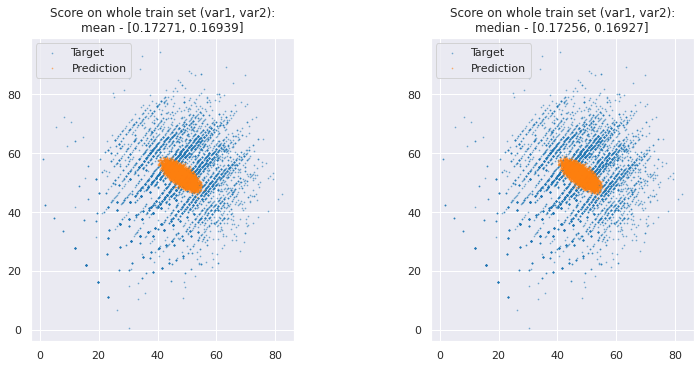


Grid point: 0006/0009
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 0.5, 'nn__hinge_dist': 1.0, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


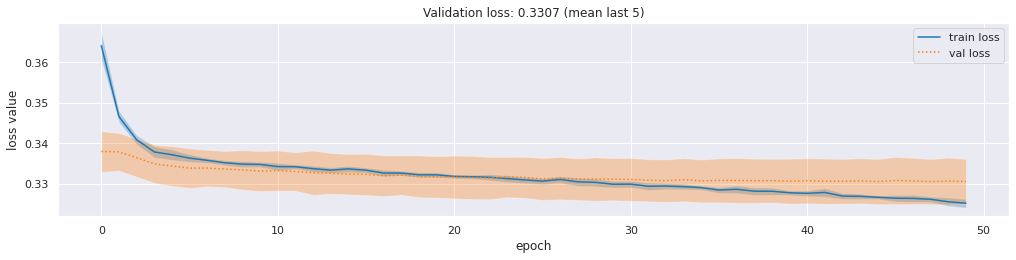

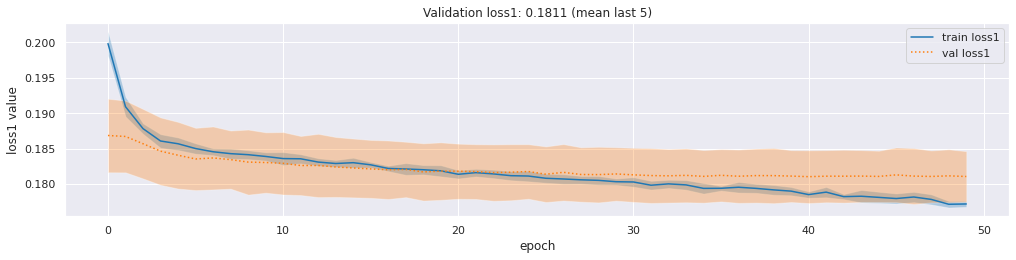

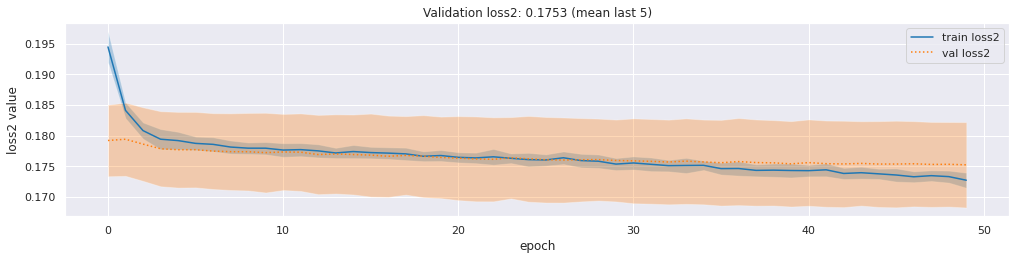

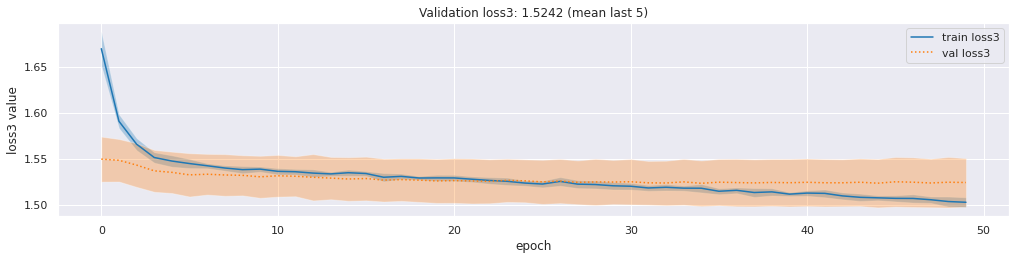

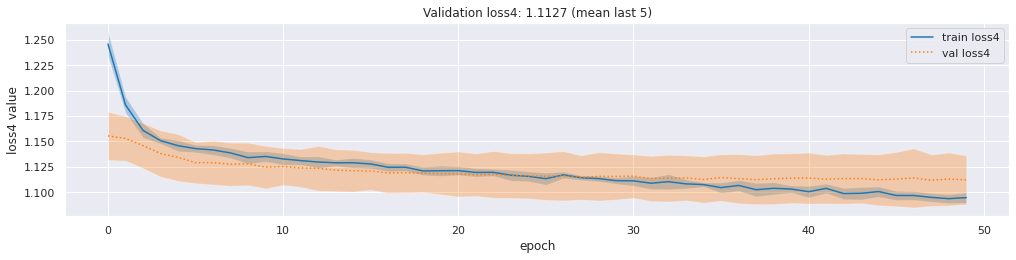

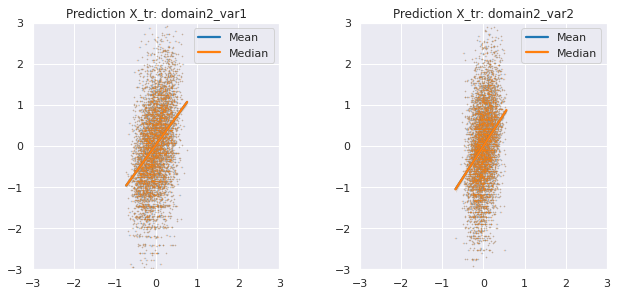

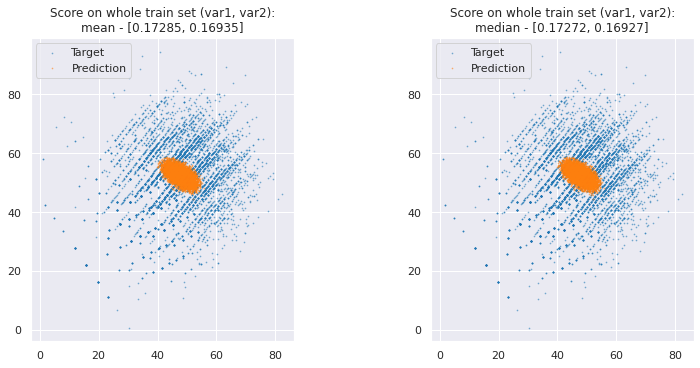


Grid point: 0007/0009
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 1.0, 'nn__hinge_dist': 0.0, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


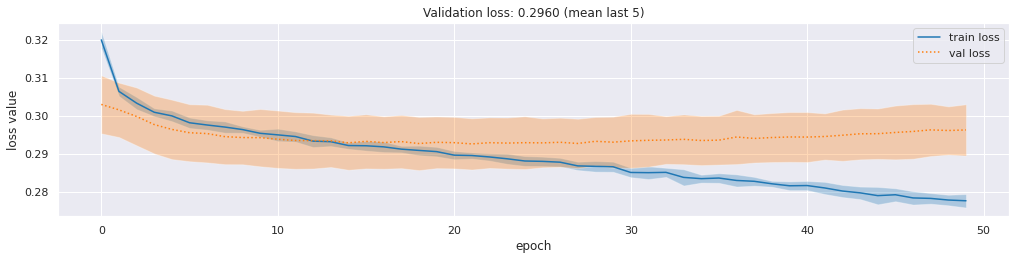

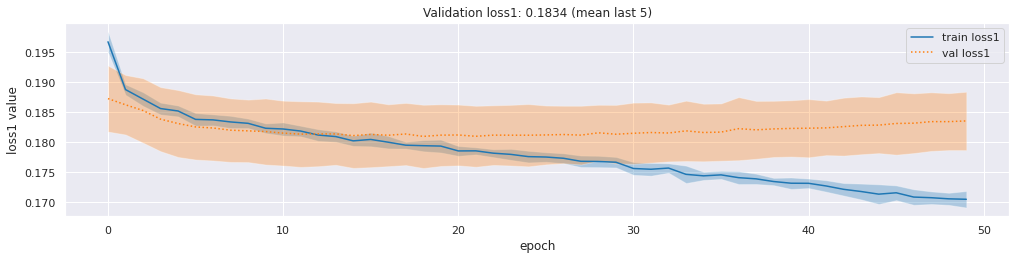

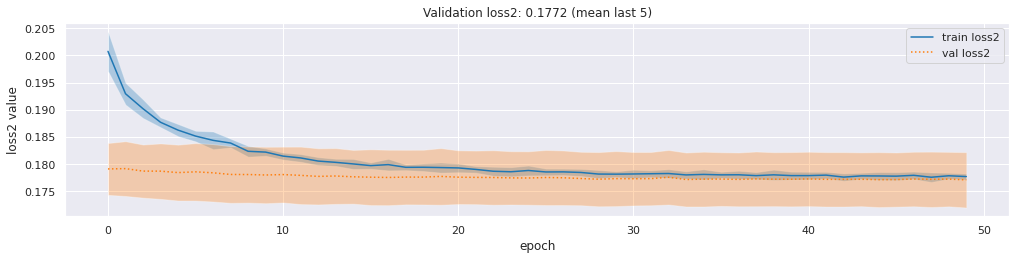

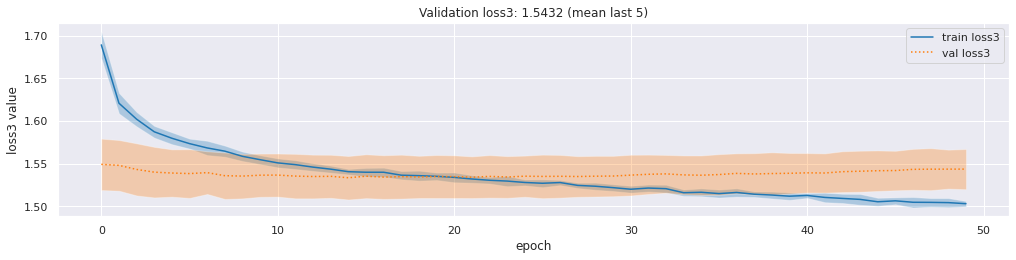

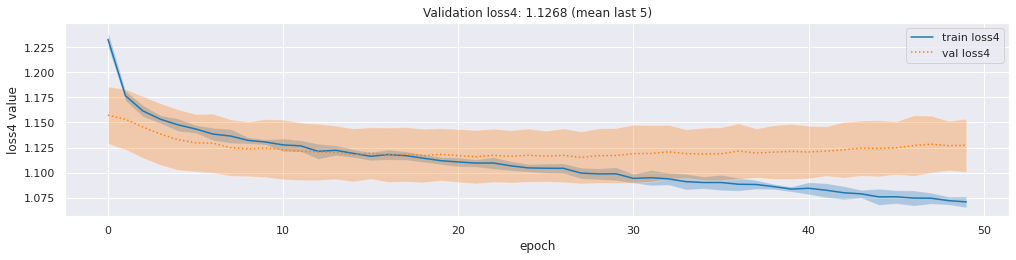

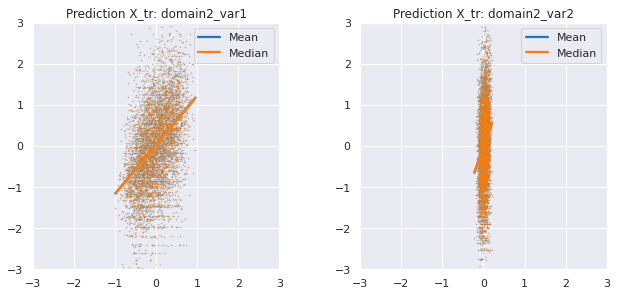

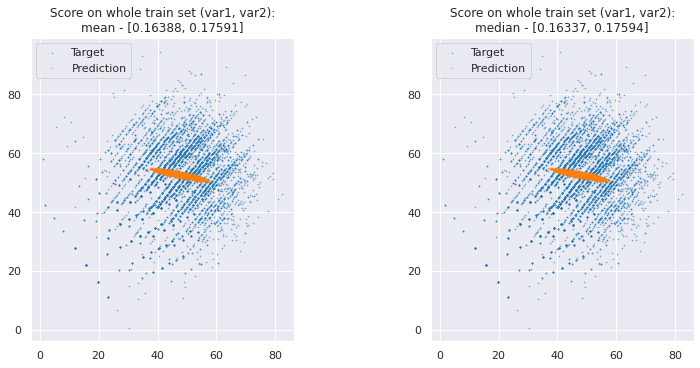


Grid point: 0008/0009
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 1.0, 'nn__hinge_dist': 0.5, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


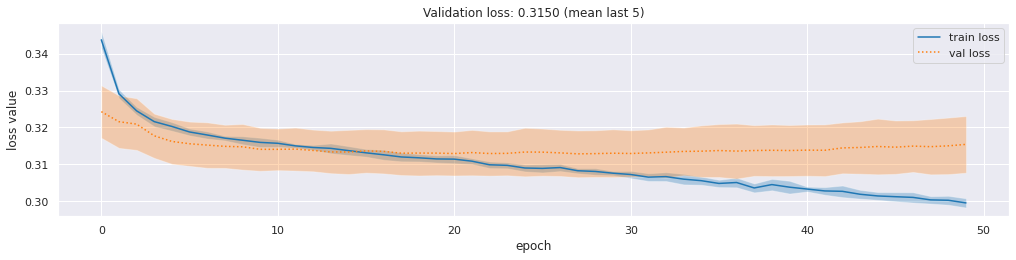

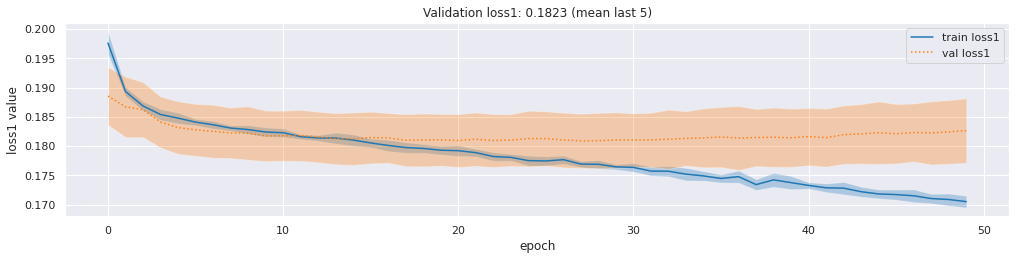

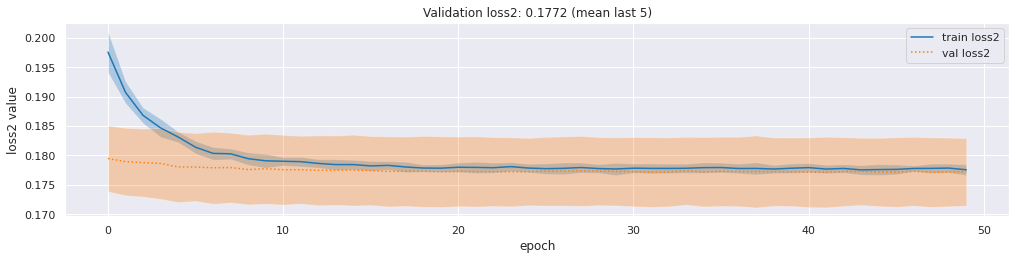

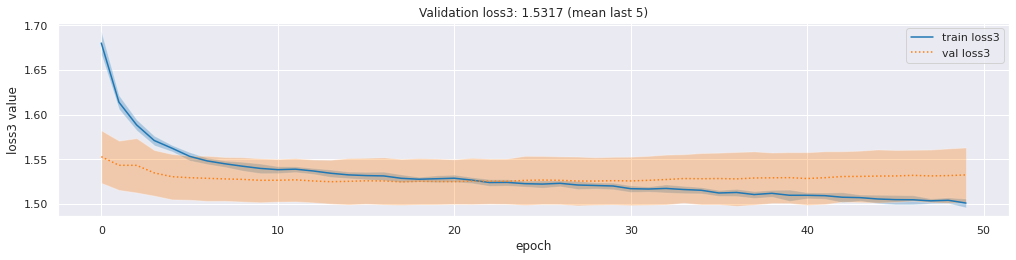

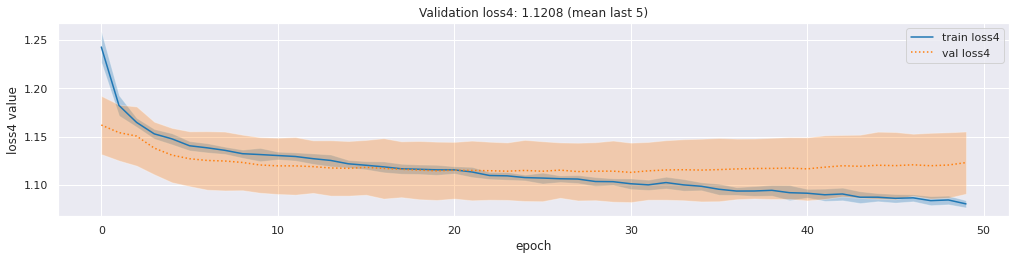

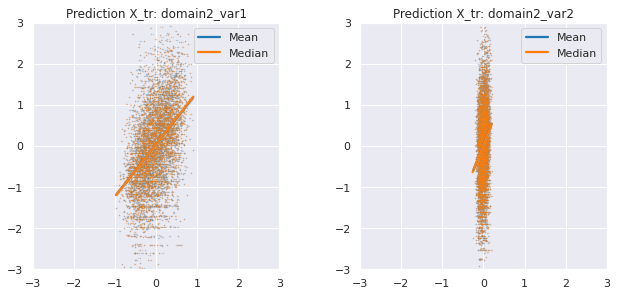

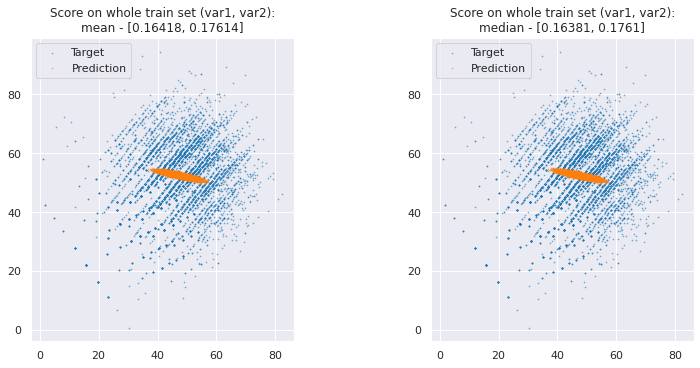


Grid point: 0009/0009
Parameters: {'batch_size': 32, 'epochs': 50, 'nn__activation': 'sigmoid', 'nn__dropout': 0.25, 'nn__hidden': (128, 32), 'nn__hinge': 1.0, 'nn__hinge_dist': 1.0, 'nn__input_size': 2835, 'nn__kernel_initializer': 'glorot_uniform', 'nn__lr': 0.05, 'nn__use_batch': True, 'nn__use_dropout': True}
CV: 01/08
CV: 02/08
CV: 03/08
CV: 04/08
CV: 05/08
CV: 06/08
CV: 07/08
CV: 08/08


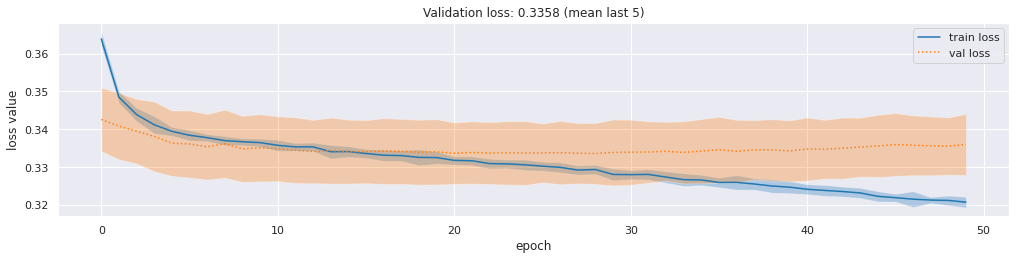

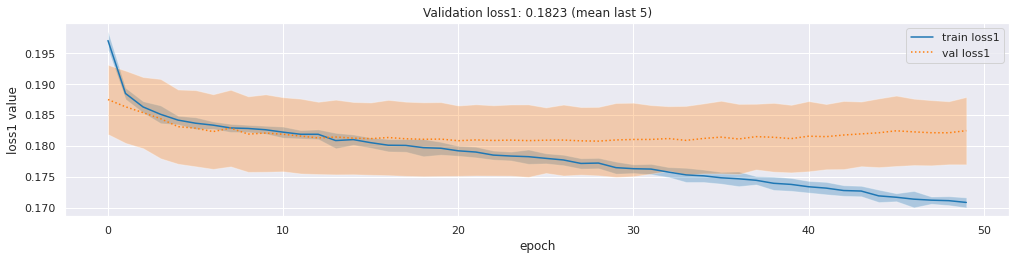

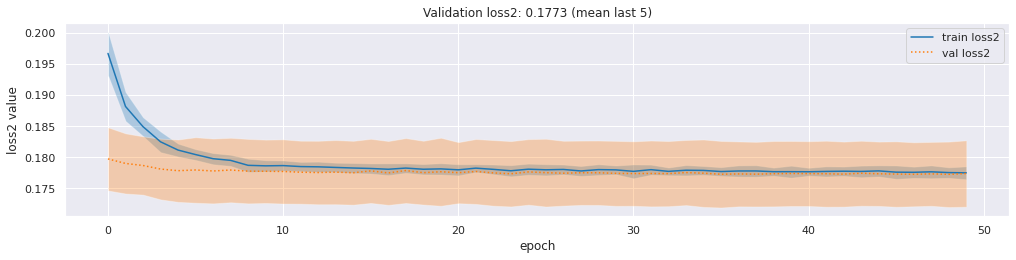

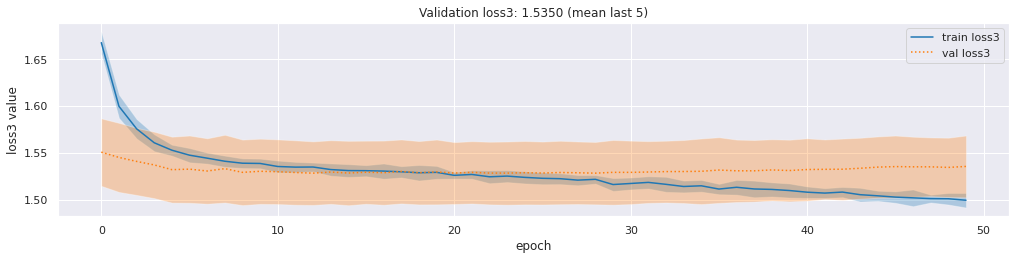

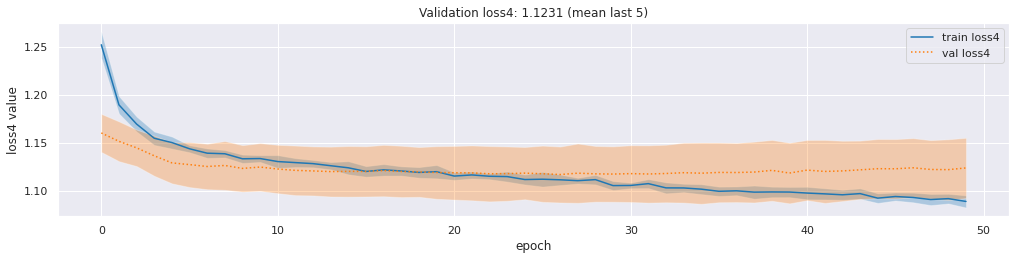

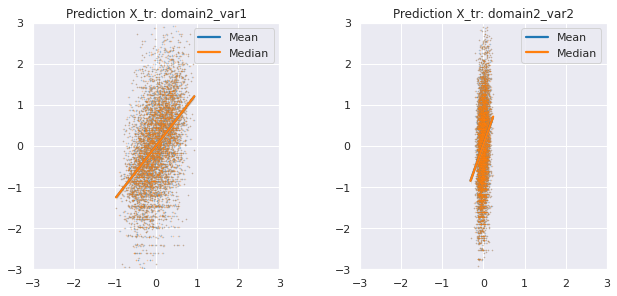

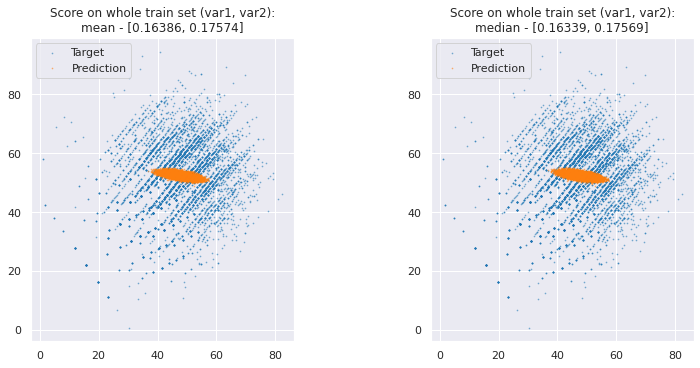

tr_mean   te_mean  tr_mean1  te_mean1  tr_mean2  te_mean2  tr_mean3  \
0  0.276872  0.287297  0.182584  0.182233  0.168414  0.175748  1.506534   
1  0.298270  0.308484  0.183170  0.182465  0.168380  0.176112  1.505192   
2  0.319048  0.329045  0.183497  0.182957  0.168568  0.176045  1.504797   
3  0.282691  0.290206  0.176865  0.181231  0.173312  0.175429  1.505354   
4  0.304915  0.309752  0.177533  0.180842  0.173202  0.175106  1.505848   
5  0.325952  0.330652  0.177664  0.181146  0.173263  0.175320  1.504887   
6  0.278238  0.296032  0.170886  0.183352  0.177804  0.177221  1.504692   
7  0.300514  0.314972  0.171132  0.182348  0.177729  0.177216  1.503525   
8  0.321358  0.335796  0.171242  0.182291  0.177583  0.177313  1.501164   

   te_mean3  tr_mean4  te_mean4  ... nn__activation nn__dropout nn__hidden  \
0  1.529392  1.084578  1.115483  ...        sigmoid        0.25  (128, 32)   
1  1.528606  1.092626  1.118841  ...        sigmoid        0.25  (128, 32)   
2  1.529996  1.102360  1.117190  ...        sigmoid        0.25  (128, 32)   
3  1.529610  1.076022  1.118754  ...        sigmoid        0.25  (128, 32)   
4  1.524003  1.085105  1.111561  ...        sigmoid        0.25  (128, 32)   
5  1.524188  1.095256  1.112695  ...        sigmoid        0.25  (128, 32)   
6  1.543234  1.073523  1.126797  ...        sigmoid        0.25  (128, 32)   
7  1.531698  1.084125  1.120786  ...        sigmoid        0.25  (128, 32)   
8  1.535045  1.091921  1.123076  ...        sigmoid        0.25  (128, 32)   

  nn__hinge nn__hinge_dist nn__input_size nn__kernel_initializer nn__lr  \
0       0.0            0.0           2835         glorot_uniform   0.05   
1       0.0            0.5           2835         glorot_uniform   0.05   
2       0.0            1.0           2835         glorot_uniform   0.05   
3       0.5            0.0           2835         glorot_uniform   0.05   
4       0.5            0.5           2835         glorot_uniform   0.05   
5       0.5            1.0           2835         glorot_uniform   0.05   
6       1.0            0.0           2835         glorot_uniform   0.05   
7       1.0            0.5           2835         glorot_uniform   0.05   
8       1.0            1.0           2835         glorot_uniform   0.05   

  nn__use_batch nn__use_dropout  
0          True            True  
1          True            True  
2          True            True  
3          True            True  
4          True            True  
5          True            True  
6          True            True  
7          True            True  
8          True            True  

[9 rows x 22 columns]

Best score at 0.287297 / 0.276872


In [28]:
# Define feature set scales (~average from my second notebook)
scale_values = [0.25, 0.025, 0.04, 0.02]

# Run model fit
preds_tr, preds_te, top_grid, df_grid, y_tr, history = run_prediction(cv=8, n=4, scale_values=scale_values)

# Feedback of overall score
print('Best score at %s / %s' % (top_grid['te_mean'], top_grid['tr_mean']))

## Observation 3

Also here, while the `hinge=0.5` and `hinge_dist=0.5` approach leads to the best model fit, the predictions are not helpfull to improve the final score.